# Préparation

## Importations

In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torch.utils.data.sampler import SubsetRandomSampler
import torch.nn.functional as F
from time import time 

import pandas as pd 

import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import seaborn as sns

## CIFAR10

In [2]:
# choose the training and test datasets
transform = torchvision.transforms.ToTensor()
train_data = torchvision.datasets.CIFAR10('data', train=True,
                              download=True, transform = transform)
test_data = torchvision.datasets.CIFAR10('data', train=False,
                             download=True, transform = transform)

100%|██████████| 170498071/170498071 [00:04<00:00, 37896180.26it/s]


Extracting data/cifar-10-python.tar.gz to data
Files already downloaded and verified


In [3]:
# obtain training indices that will be used for validation
num_train = len(train_data)
val_percentage = 0.15
indices = list(range(num_train))
split = int(np.floor(num_train * val_percentage))
train_idx, valid_idx = indices[split:], indices[:split]

In [4]:
# define samplers for obtaining training and validation batches

train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)

In [5]:
# prepare data loaders (combine dataset and sampler)
batch_size = 20
num_workers = 0

train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size,
    sampler=train_sampler, num_workers=num_workers)
valid_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, 
    sampler=valid_sampler, num_workers=num_workers)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, 
    num_workers=num_workers)

In [6]:
classes = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

## Fonction de perte customisée

In [7]:
class CustomLoss(nn.Module):
    def __init__(self):
        super(CustomLoss, self).__init__()

    def forward(self, output, target, params, device, norm, l):
        criterion = nn.CrossEntropyLoss().to(device)
        loss = criterion(output, target)
        
        if norm == 1:
          params = torch.cat([x.view(-1) for x in params])
          h = l * torch.norm(params, 1)
        
        elif norm == 2:
          params = torch.cat([x.view(-1) for x in params])
          h = l * torch.square(torch.norm(params, 2))
        
        elif norm == "weighted":
          loss.backward()

          h = []
          for p in params:
            Irr = torch.exp(-torch.abs(p.grad))
            t = torch.abs(p)**2
            h.append(torch.sum(Irr * t))

          h = l*sum(h)

        elif norm == 'no reg':
          h = torch.zeros_like(loss)
        
        else:
          print("Must define norm = 1 or norm = 2")
          return None


        return loss + h

## Architectures des réseaux

### MLP

In [8]:
# Build the architecture

class MLP(nn.Module):
  def __init__(self, dropout=False):
    super(MLP, self).__init__()

    self.fc1 = nn.Linear(32*32*3, 1024)
    self.fc2 = nn.Linear(1024, 2048)
    self.fc3 = nn.Linear(2048, 10)

    if dropout: 
      self.dropout = nn.Dropout(0.2)
    else : 
      self.dropout = nn.Identity()

  def forward(self, x):
    x = x.view(-1, 32*32*3)
    x = self.fc1(x)
    x = self.dropout(x)
    x = F.relu(x)
    x = self.fc2(x)
    x = self.dropout(x)
    x = F.relu(x)
    x = self.fc3(x)

    return x

### CNN

In [9]:
class CNN(nn.Module):
  def __init__(self, dropout=False):
    super(CNN, self).__init__()
    
    self.conv1 = nn.Conv2d(3, 16, 3, padding=1)
    self.conv2 = nn.Conv2d(16, 32, 3, padding = 1)
    self.conv3 = nn.Conv2d(32, 64, 3, padding = 1)
    
    self.pool = nn.MaxPool2d(2,2)

    if dropout: 
      self.dropout = nn.Dropout(0.2)
    else : 
      self.dropout = nn.Identity()

    self.fc1 = nn.Linear(4*4*64, 256)
    self.fc2 = nn.Linear(256, 10)
  
  def forward(self, x):

    x = self.pool(F.relu(self.conv1(x)))
    x = self.pool(F.relu(self.conv2(x)))
    x = self.pool(F.relu(self.conv3(x)))

    x = x.view(-1, 4*4*64)

    x = self.dropout(x)

    x = F.relu(self.fc1(x))
    x = self.fc2(x)

    return x

## Fonctions principales

### Entraînement/Test


In [10]:
def train(model, lambda_reg, n_epochs:int, criterion, optimizer, norm, name:str, train_on_gpu):

  if train_on_gpu:
    model.cuda()
    device = 'cuda'
  else:
    device = 'cpu'

  train_losses = []
  train_accs = []

  valid_losses = []
  valid_accs = []


  valid_loss_min = np.Inf
  t0 = time()
  for epoch in range(n_epochs): 

    train_loss = 0
    train_acc = 0

    valid_loss = 0
    valid_acc = 0 

    # Train 
    model.train()

    for data, target in train_loader:
      if train_on_gpu:
        data, target = data.cuda(), target.cuda()

      model.zero_grad()
      output = model(data)

      loss = criterion(output, target, model.parameters(), device, norm, l=lambda_reg)

      # convert output probabilities to predicted class
      _, pred = torch.max(output, 1)    
    
      # compare predictions to true label
      correct_tensor = pred.eq(target.data.view_as(pred))
      correct = np.squeeze(correct_tensor.numpy()) if not train_on_gpu else np.squeeze(correct_tensor.cpu().numpy()) # True/False * batch_size

      acc = sum(correct) 

      train_loss += loss.item()
      train_acc += acc

      loss.backward()

      optimizer.step()

    # Valid
    model.eval()
    for data,target in valid_loader:
      if train_on_gpu:
        data, target = data.cuda(), target.cuda()

      output = model(data)
      loss = criterion(output, target, model.parameters(), device, norm, l=lambda_reg)

      # convert output probabilities to predicted class
      _, pred = torch.max(output, 1)    
    
      # compare predictions to true label
      correct_tensor = pred.eq(target.data.view_as(pred))
      correct = np.squeeze(correct_tensor.numpy()) if not train_on_gpu else np.squeeze(correct_tensor.cpu().numpy()) # True/False * batch_size

      acc = sum(correct)

      valid_acc += acc
      valid_loss += loss.item()


    train_loss = train_loss/len(train_loader.sampler)
    train_acc = train_acc/len(train_loader.sampler)
    valid_loss = valid_loss/len(valid_loader.sampler)
    valid_acc = valid_acc/len(valid_loader.sampler)

    train_losses.append(train_loss)
    train_accs.append(train_acc)

    valid_losses.append(valid_loss)
    valid_accs.append(valid_acc)


    print('Epoch: {} \tTraining Loss: {:.6f} \tTraining Accuracy: {:.6f} \tValidation Loss: {:.6f} \tValidation Accuracy: {:.6f}'.format(
          epoch, train_loss, train_acc, valid_loss, valid_acc))
    
      # save model if validation loss has decreased
    if valid_loss <= valid_loss_min:
      print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
      valid_loss_min,
      valid_loss))
      torch.save(model.state_dict(), name+'_cifar.pt')
      valid_loss_min = valid_loss

  t1 = time()  
  return train_losses, train_accs, valid_losses, valid_accs, t1-t0

In [11]:
def train_irr(model, lambda_reg, n_epochs:int, criterion, optimizer, norm, name:str, train_on_gpu):
  """Fonction train pour la régularisation Irrevelance"""

  if train_on_gpu:
    model.cuda()
    device = 'cuda'
  else:
    device = 'cpu'

  train_losses = []
  train_accs = []

  valid_losses = []
  valid_accs = []


  valid_loss_min = np.Inf
  t0 = time()
  for epoch in range(n_epochs): 

    train_loss = 0
    train_acc = 0

    valid_loss = 0
    valid_acc = 0 

    # Train 
    model.train()

    for data, target in train_loader:
      if train_on_gpu:
        data, target = data.cuda(), target.cuda()

      model.zero_grad()
      output = model(data)

      loss = criterion(output, target, model.parameters(), device, norm, l=lambda_reg)

      # convert output probabilities to predicted class
      _, pred = torch.max(output, 1)    
    
      # compare predictions to true label
      correct_tensor = pred.eq(target.data.view_as(pred))
      correct = np.squeeze(correct_tensor.numpy()) if not train_on_gpu else np.squeeze(correct_tensor.cpu().numpy()) # True/False * batch_size

      acc = sum(correct) 

      train_loss += loss.item()
      train_acc += acc

      optimizer.step()

    # Valid
    model.eval()
    for data,target in valid_loader:
      if train_on_gpu:
        data, target = data.cuda(), target.cuda()

      output = model(data)
      loss = criterion(output, target, model.parameters(), device, norm, l=lambda_reg)

      # convert output probabilities to predicted class
      _, pred = torch.max(output, 1)    
    
      # compare predictions to true label
      correct_tensor = pred.eq(target.data.view_as(pred))
      correct = np.squeeze(correct_tensor.numpy()) if not train_on_gpu else np.squeeze(correct_tensor.cpu().numpy()) # True/False * batch_size

      acc = sum(correct)

      valid_acc += acc
      valid_loss += loss.item()


    train_loss = train_loss/len(train_loader.sampler)
    train_acc = train_acc/len(train_loader.sampler)
    valid_loss = valid_loss/len(valid_loader.sampler)
    valid_acc = valid_acc/len(valid_loader.sampler)

    train_losses.append(train_loss)
    train_accs.append(train_acc)

    valid_losses.append(valid_loss)
    valid_accs.append(valid_acc)


    print('Epoch: {} \tTraining Loss: {:.6f} \tTraining Accuracy: {:.6f} \tValidation Loss: {:.6f} \tValidation Accuracy: {:.6f}'.format(
          epoch, train_loss, train_acc, valid_loss, valid_acc))
    
      # save model if validation loss has decreased
    if valid_loss <= valid_loss_min:
      print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
      valid_loss_min,
      valid_loss))
      torch.save(model.state_dict(), name+'_cifar.pt')
      valid_loss_min = valid_loss

  t1 = time()  
  return train_losses, train_accs, valid_losses, valid_accs, t1-t0

In [12]:
def test(model, lambda_reg, n_epochs:int, criterion, optimizer, norm, name:str, train_on_gpu):
  model.load_state_dict(torch.load(name+'_cifar.pt'))

  if train_on_gpu:
    model.cuda()
    device = 'cuda'
  else:
    device = 'cpu'

  # track test loss
  test_loss = 0.0
  class_correct = list(0. for i in range(10))
  class_total = list(0. for i in range(10))

  model.eval()

  # iterate over test data
  for data, target in test_loader:
    # move tensors to GPU if CUDA is available
    if train_on_gpu:
        data, target = data.cuda(), target.cuda()
    # forward pass: compute predicted outputs by passing inputs to the model
    output = model(data)
    # calculate the batch loss
    loss = criterion(output, target, model.parameters(), device, norm, l = lambda_reg)
    # update test loss 
    test_loss += loss.item()
    # convert output probabilities to predicted class
    _, pred = torch.max(output, 1)    
    # compare predictions to true label
    correct_tensor = pred.eq(target.data.view_as(pred))
    correct = np.squeeze(correct_tensor.numpy()) if not train_on_gpu else np.squeeze(correct_tensor.cpu().numpy())
    # calculate test accuracy for each object class
    for i in range(batch_size):
        label = target.data[i]
        class_correct[label] += correct[i].item()
        class_total[label] += 1

  # average test loss
  test_loss = test_loss/len(test_loader.dataset)
  print('Test Loss: {:.6f}\n'.format(test_loss))

  for i in range(10):
    if class_total[i] > 0:
        print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (
            classes[i], 100 * class_correct[i] / class_total[i],
            np.sum(class_correct[i]), np.sum(class_total[i])))
    else:
        print('Test Accuracy of %5s: N/A (no training examples)' % (classes[i]))

  print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (
    100. * np.sum(class_correct) / np.sum(class_total),
    np.sum(class_correct), np.sum(class_total)))
  
  return test_loss, class_correct, class_total, 100. * np.sum(class_correct) / np.sum(class_total)

### Fonctions pour analyse

In [34]:
def save_results(arrs, name):
  df = pd.DataFrame(np.array(arrs), index = ['train_loss', 'train_acc', 'val_loss', 'val_acc', 'time', 'test_loss', 'test_correct', 'test_total', 'test_acc'])
  df.to_csv(name+'.csv')

In [35]:
def clean(seq_string):
    split_seq = seq_string.split(',')
    if len(split_seq)>1:
      split_seq[0] = split_seq[0][1:]
      split_seq[-1] = split_seq[-1][:-1]
    return list(map(float, split_seq))

def preprocess_csv(file):
  df = pd.read_csv(file, sep=',',index_col = 0, names = ['values'], header=0, converters={'values': clean})
  return df

In [36]:
def get_model(name):
  # name du type : model_architecture_norm_lambda_cifar.pt
  attributs = name.split('_')

  train_on_gpu = torch.cuda.is_available()
  if train_on_gpu:
    device = 'cuda'
  else:
    device = 'cpu'

  if attributs[1]=='MLP':
    model = MLP()
    model.load_state_dict(torch.load(name, map_location=torch.device(device)))

  elif attributs[1]=='CNN':
    model = CNN()
    model.load_state_dict(torch.load(name, map_location=torch.device(device)))
  
  elif attributs[1]=='RESNET':
    model = torch.hub.load('pytorch/vision:v0.10.0', 'resnet34', pretrained=False)
    model.load_state_dict(torch.load(name, map_location=torch.device(device)))
  
  elif attributs[1]=='DNN':
    model = torch.hub.load('pytorch/vision:v0.10.0', 'densenet121', pretrained=False)
    model.load_state_dict(torch.load(name, map_location=torch.device(device)))
  
  else : 
    print("Erreur: modèle non utilisé")
    return None
  
  return model

In [37]:
def count_parameters(model, layer_name):
  '''layer_name : str
          - model = MLP : layer_name = "fc1.weight"
          - model = CNN : layer_name = "conv1.weight"
          - model = RESNET : layer_name = "conv1.weight"
          - model = DNN : layer_name = "features.conv0.weight"
  '''

  for name, parameter in model.named_parameters():
    if name==layer_name: 
      y = parameter.detach().numpy()
      t = parameter.numel()
      yhc = torch.histc(parameter, bins=1, min = -1e-3, max = 1e-3)

  print("Pour la couche "+layer_name[:-7]+
        " : \n{0:.0f} de paramètres sont mis à 0 \nEt il y a {1:.0f} de paramètres, soit un pourcentage de {2:.2f}% \n Il en reste donc {3:.0f} ({4:.2f}).".format(yhc.sum(), t, yhc.sum()/t*100, t-yhc.sum(), 100-yhc.sum()/t*100))


In [38]:
def distrib_weight_simple(model_name, reg_name, model, layer_name):
  '''
  model_name : 
          - MLP
          - CNN
          - RESNET
          - DNN

  reg_name : str 
          - "L1"
          - "Squared-L2"
          - "Non-pertinence"
  
  layer_name : str
          - model = MLP : layer_name = "fc1.weight"
          - model = CNN : layer_name = "conv1.weight"
          - model = RESNET : layer_name = "conv1.weight"
          - model = DNN : layer_name = "features.conv0.weight"
  '''

  if model_name=='MLP':
    model2 = MLP()

  elif model_name=='CNN':
    model2 = CNN()
  
  elif model_name=='RESNET':
    model2 = torch.hub.load('pytorch/vision:v0.10.0', 'resnet34', pretrained=False)
  
  elif model_name=='DNN':
    model2 = torch.hub.load('pytorch/vision:v0.10.0', 'densenet121', pretrained=False)  

  for name, parameter in model.named_parameters():
    if name==layer_name: 
      y = parameter.detach().numpy()
      t = parameter.numel()
      
  for name, parameter in model2.named_parameters():
    if name==layer_name: 
      y2 = parameter.detach().numpy()

  sns.set_palette("Set2")

  fig, ax = plt.subplots()

  sns.histplot(x=y2.reshape(-1), bins= 20, stat='frequency', label='initiale')
  sns.histplot(x=y.reshape(-1), bins= 100, stat='frequency', label='finale')

  plt.legend(bbox_to_anchor=(1,1))
  plt.suptitle("Répartition des poids :", fontweight="bold")
  plt.title(model_name + " avec "+ reg_name+' sur '+ layer_name[:-7]+' : '+str(t)+' paramètres')
  plt.ylabel("Fréquence")
  
  file_name = 'repart_weight_'+model_name+'_'+layer_name[:-7]+'_'+reg_name.split('"')[1]+'.png'
  plt.savefig(file_name)
  
  plt.show()

In [39]:
def distrib_weight_count(model_name, reg_name, model, layer_name):
  '''
  model_name : 
          - MLP
          - CNN
          - RESNET
          - DNN

  reg_name : str 
          - "L1"
          - "Squared-L2"
          - "Non-pertinence"
  
  layer_name : str
          - model = MLP : layer_name = "fc1.weight"
          - model = CNN : layer_name = "conv1.weight"
          - model = RESNET : layer_name = "conv1.weight"
          - model = DNN : layer_name = "features.conv0.weight"
  '''
  
  if model_name=='MLP':
    model2 = MLP()

  elif model_name=='CNN':
    model2 = CNN()
  
  elif model_name=='RESNET':
    model2 = torch.hub.load('pytorch/vision:v0.10.0', 'resnet34', pretrained=False)
  
  elif model_name=='DNN':
    model2 = torch.hub.load('pytorch/vision:v0.10.0', 'densenet121', pretrained=False)  

  for name, parameter in model.named_parameters():
    if name==layer_name: 
      y = parameter.detach().numpy()
      t = parameter.numel()

  for name, parameter in model2.named_parameters():
    if name==layer_name: 
      y2 = parameter.detach().numpy()

  sns.set_palette("Set2")

  fig, ax = plt.subplots()

  sns.histplot(x=y2.reshape(-1), bins= 20, label='initiale')
  sns.histplot(x=y.reshape(-1), bins= 100, label='finale')

  plt.legend(bbox_to_anchor=(1,1))
  plt.suptitle("Répartition des poids :", fontweight="bold")
  plt.title(model_name + " avec "+ reg_name+' sur '+ layer_name[:-7]+' : '+str(t)+' paramètres')
  plt.ylabel("Compte")
  
  file_name = 'repart_weight_'+model_name+'_'+layer_name[:-7]+'_'+reg_name.split('"')[1]+'_count.png'
  plt.savefig(file_name)
  
  plt.show()

In [42]:
def plot_per_epoch_lambdacomp(model_name, reg_name, df_l1, df_l2, df_l3, df_l0, no_reg=True):
  '''
  model_name : str
          - MLP
          - CNN
          - RESNET
          - DNN

  reg_name : str 
          - "L1"
          - "Squared-L2"
          - "Non-pertinence"
  
  layer_name : str
          - model = MLP : layer_name = fc1.weight
          - model = CNN : layer_name = conv1.weight
          - model = RESNET : layer_name = conv1.weight
          - model = DNN : layer_name = features.conv0.weight
  '''

  sns.set_palette("Paired")
  palette_total = sns.color_palette("Paired")
  
  train_l1 = df_l1.iloc[1,0]
  test_l1 = df_l1.iloc[3,0]
  
  train_l2 = df_l2.iloc[1,0]
  test_l2 = df_l2.iloc[3,0]
  
  train_l3 = df_l3.iloc[1,0]
  test_l3 = df_l3.iloc[3,0]

  train_l0 = df_l0.iloc[1,0]
  test_l0 = df_l0.iloc[3,0]

  test_acc_l1 = df_l1.iloc[-1,0][0]
  test_acc_l2 = df_l2.iloc[-1,0][0]
  test_acc_l3 = df_l3.iloc[-1,0][0]
  test_acc_l0 = df_l0.iloc[-1,0][0]

  fig, ax = plt.subplots()
  
  x = np.arange(1,len(train_l1)+1, step=1)
  
  sns.lineplot(x=x, y=train_l1, label="train - $\lambda_{1}$")
  sns.lineplot(x=x, y=test_l1, label="validation - $\lambda_{1}$")
  sns.lineplot(x=x, y=train_l2, label="train - $\lambda_{2}$")
  sns.lineplot(x=x, y=test_l2, label="validation - $\lambda_{2}$")
  sns.lineplot(x=x, y=train_l3, label="train - $\lambda_{3}$")
  sns.lineplot(x=x, y=test_l3, label="validation - $\lambda_{3}$")
  
  if no_reg : 
    sns.lineplot(x=x, y=train_l0, label="train - $\lambda=0$")
    sns.lineplot(x=x, y=test_l0, label="validation - $\lambda=0$")
  
  ax.set_xticks(x)
  lgd = plt.legend(bbox_to_anchor=(0.5,-0.15))
  plt.title("Évolution du modèle "+ model_name + " avec la régularisation "+ reg_name)
  plt.xlabel("Epochs")
  plt.ylabel("Précision")

  if no_reg : 
    legend_elements = [Line2D([], [], marker='o', color='white', markerfacecolor=palette_total[1], label=str(test_acc_l1)),
                    Line2D([], [], marker='o', color='white', markerfacecolor=palette_total[3], label=str(test_acc_l2)),
                    Line2D([], [], marker='o', color='white', markerfacecolor=palette_total[5], label=str(test_acc_l3)),
                    Line2D([], [], marker='o', color='white', markerfacecolor=palette_total[7], label=str(test_acc_l0))]
  else : 
    legend_elements = [Line2D([], [], marker='o', color='white', markerfacecolor=palette_total[1], label=str(test_acc_l1)),
                    Line2D([], [], marker='o', color='white', markerfacecolor=palette_total[3], label=str(test_acc_l2)),
                    Line2D([], [], marker='o', color='white', markerfacecolor=palette_total[5], label=str(test_acc_l3))]
  
  lgd2 = fig.legend(handles=legend_elements, bbox_to_anchor=[0.75, -0.05], title="Précision sur test")
  if no_reg: 
    file_name = 'comp_lambda_'+model_name+'_'+reg_name.split('"')[1]+'_avec_noreg.png'
  else : 
    file_name = 'comp_lambda_'+model_name+'_'+reg_name.split('"')[1]+'.png'
  plt.savefig(file_name, bbox_extra_artists=(lgd,lgd2,), bbox_inches='tight')
  plt.show()  

In [43]:
def plot_per_epoch_regcomp(model_name, l_name, df_l1, df_l2, df_l3, df_l0, no_reg=True):
  '''
  model_name : str
          - MLP
          - CNN
          - RESNET
          - DNN

  l_name : str 
          - $\lambda_{0}$ (=0)
          - $\lambda_{1}$ (=1e-4)
          - $\lambda_{2}$ (=1e-3)
          - $\lambda_{3}$ (=1e-2)
  
  layer_name : str
          - model = MLP : layer_name = fc1.weight
          - model = CNN : layer_name = conv1.weight
          - model = RESNET : layer_name = conv1.weight
          - model = DNN : layer_name = features.conv0.weight
  '''

  sns.set_palette("Paired")

  palette_total = sns.color_palette("Paired")
  
  train_l1 = df_l1.iloc[1,0]
  test_l1 = df_l1.iloc[3,0]
  
  train_l2 = df_l2.iloc[1,0]
  test_l2 = df_l2.iloc[3,0]
  
  train_l3 = df_l3.iloc[1,0]
  test_l3 = df_l3.iloc[3,0]

  train_l0 = df_l0.iloc[1,0]
  test_l0 = df_l0.iloc[3,0]

  test_acc_l1 = df_l1.iloc[-1,0][0]
  test_acc_l2 = df_l2.iloc[-1,0][0]
  test_acc_l3 = df_l3.iloc[-1,0][0]
  test_acc_l0 = df_l0.iloc[-1,0][0]

  fig, ax = plt.subplots()
  
  x = np.arange(1,len(train_l1)+1, step=1)
  
  sns.lineplot(x=x, y=train_l1, label="train - L1")
  sns.lineplot(x=x, y=test_l1, label="validation - L1")
  sns.lineplot(x=x, y=train_l2, label="train - Squared-L2")
  sns.lineplot(x=x, y=test_l2, label="validation - Squared-L2")
  sns.lineplot(x=x, y=train_l3, label="train - Non-pertinence")
  sns.lineplot(x=x, y=test_l3, label="validation - Non-pertinence")
  
  if no_reg : 
    sns.lineplot(x=x, y=train_l0, label="train - Sans ($\lambda=0$)")
    sns.lineplot(x=x, y=test_l0, label="validation - Sans ($\lambda=0$)")
  
  ax.set_xticks(x)
  lgd = plt.legend(bbox_to_anchor=(0.5,-0.15))
  plt.title("Évolution du modèle "+ model_name + " avec "+l_name)
  plt.xlabel("Epochs")
  plt.ylabel("Précision")

  if no_reg : 
    legend_elements = [Line2D([], [], marker='o', color='white', markerfacecolor=palette_total[1], label=str(test_acc_l1)),
                    Line2D([], [], marker='o', color='white', markerfacecolor=palette_total[3], label=str(test_acc_l2)),
                    Line2D([], [], marker='o', color='white', markerfacecolor=palette_total[5], label=str(test_acc_l3)),
                    Line2D([], [], marker='o', color='white', markerfacecolor=palette_total[7], label=str(test_acc_l0))]
  else : 
    legend_elements = [Line2D([], [], marker='o', color='white', markerfacecolor=palette_total[1], label=str(test_acc_l1)),
                    Line2D([], [], marker='o', color='white', markerfacecolor=palette_total[3], label=str(test_acc_l2)),
                    Line2D([], [], marker='o', color='white', markerfacecolor=palette_total[5], label=str(test_acc_l3))]
  
  lgd2 = fig.legend(handles=legend_elements, bbox_to_anchor=[0.75, -0.05], title="Précision sur test")

  file_name = 'comp_reg_'+model_name+'_l'+l_name[-3]+'.png'

  plt.savefig(file_name, bbox_extra_artists=(lgd,lgd2,), bbox_inches='tight')
  plt.show()  

## Hyperparamètres 

In [21]:
train_on_gpu = torch.cuda.is_available()

In [22]:
n_epochs = 20

# Expériences 

## L1

In [ ]:
norm = 1

### $\lambda_{1} = 10^{-4}$

In [ ]:
lambda_reg = 1e-4

#### MLP

In [ ]:
model_MLP_L1_lambda1 = MLP()

criterion = CustomLoss()
optimizer = optim.SGD(params = model_MLP_L1_lambda1.parameters(), lr = 0.03)

In [ ]:
train_loss_MLP_L1_lambda1, train_acc_MLP_L1_lambda1, valid_loss_MLP_L1_lambda1, valid_acc_MLP_L1_lambda1, time_MLP_L1_lambda1 = train(model_MLP_L1_lambda1, lambda_reg, n_epochs, criterion, optimizer, norm, 'model_MLP_L1_lambda1', train_on_gpu)

Epoch: 0 	Training Loss: 0.330569 	Training Accuracy: 0.297459 	Validation Loss: 0.258174 	Validation Accuracy: 0.353333
Validation loss decreased (inf --> 0.258174).  Saving model ...
Epoch: 1 	Training Loss: 0.212142 	Training Accuracy: 0.348212 	Validation Loss: 0.168959 	Validation Accuracy: 0.382933
Validation loss decreased (0.258174 --> 0.168959).  Saving model ...
Epoch: 2 	Training Loss: 0.147798 	Training Accuracy: 0.356306 	Validation Loss: 0.126886 	Validation Accuracy: 0.370000
Validation loss decreased (0.168959 --> 0.126886).  Saving model ...
Epoch: 3 	Training Loss: 0.116543 	Training Accuracy: 0.365647 	Validation Loss: 0.102471 	Validation Accuracy: 0.413067
Validation loss decreased (0.126886 --> 0.102471).  Saving model ...
Epoch: 4 	Training Loss: 0.102013 	Training Accuracy: 0.376659 	Validation Loss: 0.095164 	Validation Accuracy: 0.411733
Validation loss decreased (0.102471 --> 0.095164).  Saving model ...
Epoch: 5 	Training Loss: 0.097797 	Training Accuracy: 0

In [ ]:
test_loss_MLP_L1_lambda1, class_correct_MLP_L1_lambda1, class_total_MLP_L1_lambda1, test_acc_MLP_L1_lambda1 = test(model_MLP_L1_lambda1, lambda_reg, n_epochs, criterion, optimizer, norm, 'model_MLP_L1_lambda1', train_on_gpu)

Test Loss: 0.087502

Test Accuracy of airplane: 38% (388/1000)
Test Accuracy of automobile: 57% (576/1000)
Test Accuracy of  bird:  8% (81/1000)
Test Accuracy of   cat: 42% (427/1000)
Test Accuracy of  deer: 54% (544/1000)
Test Accuracy of   dog: 24% (240/1000)
Test Accuracy of  frog: 55% (550/1000)
Test Accuracy of horse: 50% (504/1000)
Test Accuracy of  ship: 64% (647/1000)
Test Accuracy of truck: 57% (579/1000)

Test Accuracy (Overall): 45% (4536/10000)


In [ ]:
arrs = [train_loss_MLP_L1_lambda1, train_acc_MLP_L1_lambda1, valid_loss_MLP_L1_lambda1, valid_acc_MLP_L1_lambda1, time_MLP_L1_lambda1, test_loss_MLP_L1_lambda1, class_correct_MLP_L1_lambda1, class_total_MLP_L1_lambda1, test_acc_MLP_L1_lambda1]

In [ ]:
save_results(arrs, "MLP_L1_lambda1")

<ipython-input-25-b3a6eac2ef9e>:5: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  df = pd.DataFrame(np.array(arrs), index = ['train_loss', 'train_acc', 'val_loss', 'val_acc', 'time', 'test_loss', 'test_correct', 'test_total', 'test_acc'])


##### Dropout

In [ ]:
model_MLP_L1_lambda1_dropout = MLP_dropout()

criterion = CustomLoss()
optimizer = optim.SGD(params = model_MLP_L1_lambda1_dropout.parameters(), lr = 0.03)

In [ ]:
train_loss_MLP_L1_lambda1_dropout, train_acc_MLP_L1_lambda1_dropout, valid_loss_MLP_L1_lambda1_dropout, valid_acc_MLP_L1_lambda1_dropout, time_MLP_L1_lambda1_dropout = train(model_MLP_L1_lambda1_dropout, lambda_reg, n_epochs, criterion, optimizer, norm, 'model_MLP_L1_lambda1_dropout', train_on_gpu)

Epoch: 0 	Training Loss: 0.330569 	Training Accuracy: 0.297459 	Validation Loss: 0.258174 	Validation Accuracy: 0.353333
Validation loss decreased (inf --> 0.258174).  Saving model ...
Epoch: 1 	Training Loss: 0.212142 	Training Accuracy: 0.348212 	Validation Loss: 0.168959 	Validation Accuracy: 0.382933
Validation loss decreased (0.258174 --> 0.168959).  Saving model ...
Epoch: 2 	Training Loss: 0.147798 	Training Accuracy: 0.356306 	Validation Loss: 0.126886 	Validation Accuracy: 0.370000
Validation loss decreased (0.168959 --> 0.126886).  Saving model ...
Epoch: 3 	Training Loss: 0.116543 	Training Accuracy: 0.365647 	Validation Loss: 0.102471 	Validation Accuracy: 0.413067
Validation loss decreased (0.126886 --> 0.102471).  Saving model ...
Epoch: 4 	Training Loss: 0.102013 	Training Accuracy: 0.376659 	Validation Loss: 0.095164 	Validation Accuracy: 0.411733
Validation loss decreased (0.102471 --> 0.095164).  Saving model ...
Epoch: 5 	Training Loss: 0.097797 	Training Accuracy: 0

In [ ]:
test_loss_MLP_L1_lambda1_dropout, class_correct_MLP_L1_lambda1_dropout, class_total_MLP_L1_lambda1_dropout, test_acc_MLP_L1_lambda1_dropout = test(model_MLP_L1_lambda1_dropout, lambda_reg, n_epochs, criterion, optimizer, norm, 'model_MLP_L1_lambda1_dropout', train_on_gpu)

Test Loss: 0.087502

Test Accuracy of airplane: 38% (388/1000)
Test Accuracy of automobile: 57% (576/1000)
Test Accuracy of  bird:  8% (81/1000)
Test Accuracy of   cat: 42% (427/1000)
Test Accuracy of  deer: 54% (544/1000)
Test Accuracy of   dog: 24% (240/1000)
Test Accuracy of  frog: 55% (550/1000)
Test Accuracy of horse: 50% (504/1000)
Test Accuracy of  ship: 64% (647/1000)
Test Accuracy of truck: 57% (579/1000)

Test Accuracy (Overall): 45% (4536/10000)


In [ ]:
arrs = [train_loss_MLP_L1_lambda1_dropout, train_acc_MLP_L1_lambda1_dropout, valid_loss_MLP_L1_lambda1_dropout, valid_acc_MLP_L1_lambda1_dropout, time_MLP_L1_lambda1_dropout, test_loss_MLP_L1_lambda1_dropout, class_correct_MLP_L1_lambda1_dropout, class_total_MLP_L1_lambda1_dropout, test_acc_MLP_L1_lambda1_dropout]

In [ ]:
save_results(arrs, "MLP_L1_lambda1_dropout")

<ipython-input-25-b3a6eac2ef9e>:5: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  df = pd.DataFrame(np.array(arrs), index = ['train_loss', 'train_acc', 'val_loss', 'val_acc', 'time', 'test_loss', 'test_correct', 'test_total', 'test_acc'])


#### CNN

In [ ]:
model_CNN_L1_lambda1 = CNN()

criterion = CustomLoss()
optimizer = optim.SGD(params=model_CNN_L1_lambda1.parameters(), lr = 0.03)

In [ ]:
train_loss_CNN_L1_lambda1, train_acc_CNN_L1_lambda1, valid_loss_CNN_L1_lambda1, valid_acc_CNN_L1_lambda1, time_CNN_L1_lambda1 = train(model_CNN_L1_lambda1, lambda_reg, n_epochs, criterion, optimizer, norm, 'model_CNN_L1_lambda1', train_on_gpu)

Epoch: 0 	Training Loss: 0.123674 	Training Accuracy: 0.241247 	Validation Loss: 0.107462 	Validation Accuracy: 0.355467
Validation loss decreased (inf --> 0.107462).  Saving model ...
Epoch: 1 	Training Loss: 0.098216 	Training Accuracy: 0.403859 	Validation Loss: 0.086478 	Validation Accuracy: 0.466267
Validation loss decreased (0.107462 --> 0.086478).  Saving model ...
Epoch: 2 	Training Loss: 0.083290 	Training Accuracy: 0.495694 	Validation Loss: 0.078165 	Validation Accuracy: 0.521333
Validation loss decreased (0.086478 --> 0.078165).  Saving model ...
Epoch: 3 	Training Loss: 0.075070 	Training Accuracy: 0.548071 	Validation Loss: 0.072613 	Validation Accuracy: 0.571067
Validation loss decreased (0.078165 --> 0.072613).  Saving model ...
Epoch: 4 	Training Loss: 0.069392 	Training Accuracy: 0.590588 	Validation Loss: 0.067716 	Validation Accuracy: 0.595333
Validation loss decreased (0.072613 --> 0.067716).  Saving model ...
Epoch: 5 	Training Loss: 0.065985 	Training Accuracy: 0

In [ ]:
test_loss_CNN_L1_lambda1, class_correct_CNN_L1_lambda1, class_total_CNN_L1_lambda1, test_acc_CNN_L1_lambda1 = test(model_CNN_L1_lambda1, lambda_reg, n_epochs, criterion, optimizer, norm, 'model_CNN_L1_lambda1', train_on_gpu)

Test Loss: 0.058276

Test Accuracy of airplane: 72% (728/1000)
Test Accuracy of automobile: 85% (856/1000)
Test Accuracy of  bird: 51% (515/1000)
Test Accuracy of   cat: 51% (517/1000)
Test Accuracy of  deer: 63% (639/1000)
Test Accuracy of   dog: 62% (625/1000)
Test Accuracy of  frog: 83% (830/1000)
Test Accuracy of horse: 69% (697/1000)
Test Accuracy of  ship: 81% (810/1000)
Test Accuracy of truck: 74% (743/1000)

Test Accuracy (Overall): 69% (6960/10000)


In [ ]:
arrs = [train_loss_CNN_L1_lambda1, train_acc_CNN_L1_lambda1, valid_loss_CNN_L1_lambda1, valid_acc_CNN_L1_lambda1, time_CNN_L1_lambda1, test_loss_CNN_L1_lambda1, class_correct_CNN_L1_lambda1, class_total_CNN_L1_lambda1, test_acc_CNN_L1_lambda1]

In [ ]:
save_results(arrs, "CNN_L1_lambda1")

<ipython-input-25-b3a6eac2ef9e>:5: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  df = pd.DataFrame(np.array(arrs), index = ['train_loss', 'train_acc', 'val_loss', 'val_acc', 'time', 'test_loss', 'test_correct', 'test_total', 'test_acc'])


##### Dropout

In [ ]:
model_CNN_L1_lambda1_dropout = CNN_dropout()

criterion = CustomLoss()
optimizer = optim.SGD(params=model_CNN_L1_lambda1_dropout.parameters(), lr = 0.03)

In [ ]:
train_loss_CNN_L1_lambda1_dropout, train_acc_CNN_L1_lambda1_dropout, valid_loss_CNN_L1_lambda1_dropout, valid_acc_CNN_L1_lambda1_dropout, time_CNN_L1_lambda1_dropout = train(model_CNN_L1_lambda1_dropout, lambda_reg, n_epochs, criterion, optimizer, norm, 'model_CNN_L1_lambda1_dropout', train_on_gpu)

Epoch: 0 	Training Loss: 0.123674 	Training Accuracy: 0.241247 	Validation Loss: 0.107462 	Validation Accuracy: 0.355467
Validation loss decreased (inf --> 0.107462).  Saving model ...
Epoch: 1 	Training Loss: 0.098216 	Training Accuracy: 0.403859 	Validation Loss: 0.086478 	Validation Accuracy: 0.466267
Validation loss decreased (0.107462 --> 0.086478).  Saving model ...
Epoch: 2 	Training Loss: 0.083290 	Training Accuracy: 0.495694 	Validation Loss: 0.078165 	Validation Accuracy: 0.521333
Validation loss decreased (0.086478 --> 0.078165).  Saving model ...
Epoch: 3 	Training Loss: 0.075070 	Training Accuracy: 0.548071 	Validation Loss: 0.072613 	Validation Accuracy: 0.571067
Validation loss decreased (0.078165 --> 0.072613).  Saving model ...
Epoch: 4 	Training Loss: 0.069392 	Training Accuracy: 0.590588 	Validation Loss: 0.067716 	Validation Accuracy: 0.595333
Validation loss decreased (0.072613 --> 0.067716).  Saving model ...
Epoch: 5 	Training Loss: 0.065985 	Training Accuracy: 0

In [ ]:
test_loss_CNN_L1_lambda1_dropout, class_correct_CNN_L1_lambda1_dropout, class_total_CNN_L1_lambda1_dropout, test_acc_CNN_L1_lambda1_dropout = test(model_CNN_L1_lambda1_dropout, lambda_reg, n_epochs, criterion, optimizer, norm, 'model_CNN_L1_lambda1_dropout', train_on_gpu)

Test Loss: 0.058276

Test Accuracy of airplane: 72% (728/1000)
Test Accuracy of automobile: 85% (856/1000)
Test Accuracy of  bird: 51% (515/1000)
Test Accuracy of   cat: 51% (517/1000)
Test Accuracy of  deer: 63% (639/1000)
Test Accuracy of   dog: 62% (625/1000)
Test Accuracy of  frog: 83% (830/1000)
Test Accuracy of horse: 69% (697/1000)
Test Accuracy of  ship: 81% (810/1000)
Test Accuracy of truck: 74% (743/1000)

Test Accuracy (Overall): 69% (6960/10000)


In [ ]:
arrs = [train_loss_CNN_L1_lambda1_dropout, train_acc_CNN_L1_lambda1_dropout, valid_loss_CNN_L1_lambda1_dropout, valid_acc_CNN_L1_lambda1_dropout, time_CNN_L1_lambda1_dropout, test_loss_CNN_L1_lambda1_dropout, class_correct_CNN_L1_lambda1_dropout, class_total_CNN_L1_lambda1_dropout, test_acc_CNN_L1_lambda1_dropout]

In [ ]:
save_results(arrs, "CNN_L1_lambda1_dropout")

<ipython-input-25-b3a6eac2ef9e>:5: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  df = pd.DataFrame(np.array(arrs), index = ['train_loss', 'train_acc', 'val_loss', 'val_acc', 'time', 'test_loss', 'test_correct', 'test_total', 'test_acc'])


#### ResNet34

In [ ]:
model_RESNET_L1_lambda1 = torch.hub.load('pytorch/vision:v0.10.0', 'resnet34', pretrained=False)

criterion = CustomLoss()
optimizer = optim.SGD(params = model_RESNET_L1_lambda1.parameters(), lr = 0.03)

Downloading: "https://github.com/pytorch/vision/zipball/v0.10.0" to /root/.cache/torch/hub/v0.10.0.zip
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


In [ ]:
train_loss_RESNET_L1_lambda1, train_acc_RESNET_L1_lambda1, valid_loss_RESNET_L1_lambda1, valid_acc_RESNET_L1_lambda1, time_RESNET_L1_lambda1 = train(model_RESNET_L1_lambda1, lambda_reg, n_epochs, criterion, optimizer, norm, 'model_RESNET_L1_lambda1', train_on_gpu)

Epoch: 0 	Training Loss: 2.031158 	Training Accuracy: 0.389929 	Validation Loss: 1.724531 	Validation Accuracy: 0.476667
Validation loss decreased (inf --> 1.724531).  Saving model ...
Epoch: 1 	Training Loss: 1.465118 	Training Accuracy: 0.533294 	Validation Loss: 1.228227 	Validation Accuracy: 0.602933
Validation loss decreased (1.724531 --> 1.228227).  Saving model ...
Epoch: 2 	Training Loss: 1.043771 	Training Accuracy: 0.607765 	Validation Loss: 0.904605 	Validation Accuracy: 0.460000
Validation loss decreased (1.228227 --> 0.904605).  Saving model ...
Epoch: 3 	Training Loss: 0.741453 	Training Accuracy: 0.644424 	Validation Loss: 0.631938 	Validation Accuracy: 0.602533
Validation loss decreased (0.904605 --> 0.631938).  Saving model ...
Epoch: 4 	Training Loss: 0.534553 	Training Accuracy: 0.663271 	Validation Loss: 0.472290 	Validation Accuracy: 0.572133
Validation loss decreased (0.631938 --> 0.472290).  Saving model ...
Epoch: 5 	Training Loss: 0.395023 	Training Accuracy: 0

In [ ]:
test_loss_RESNET_L1_lambda1, class_correct_RESNET_L1_lambda1, class_total_RESNET_L1_lambda1, test_acc_RESNET_L1_lambda1 = test(model_RESNET_L1_lambda1, lambda_reg, n_epochs, criterion, optimizer, norm, 'model_RESNET_L1_lambda1', train_on_gpu)

Test Loss: 0.133156

Test Accuracy of airplane: 84% (840/1000)
Test Accuracy of automobile: 78% (787/1000)
Test Accuracy of  bird: 59% (594/1000)
Test Accuracy of   cat: 71% (713/1000)
Test Accuracy of  deer: 66% (660/1000)
Test Accuracy of   dog: 52% (524/1000)
Test Accuracy of  frog: 75% (759/1000)
Test Accuracy of horse: 81% (817/1000)
Test Accuracy of  ship: 81% (810/1000)
Test Accuracy of truck: 88% (889/1000)

Test Accuracy (Overall): 73% (7393/10000)


In [ ]:
arrs = [train_loss_RESNET_L1_lambda1, train_acc_RESNET_L1_lambda1, valid_loss_RESNET_L1_lambda1, valid_acc_RESNET_L1_lambda1, time_RESNET_L1_lambda1, test_loss_RESNET_L1_lambda1, class_correct_RESNET_L1_lambda1, class_total_RESNET_L1_lambda1, test_acc_RESNET_L1_lambda1]

In [ ]:
save_results(arrs, "RESNET_L1_lambda1")

<ipython-input-25-b3a6eac2ef9e>:5: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  df = pd.DataFrame(np.array(arrs), index = ['train_loss', 'train_acc', 'val_loss', 'val_acc', 'time', 'test_loss', 'test_correct', 'test_total', 'test_acc'])


#### DenseNet121

In [ ]:
model_DNN_L1_lambda1 = torch.hub.load('pytorch/vision:v0.10.0', 'densenet121', pretrained=False)

criterion = CustomLoss()
optimizer = optim.SGD(params=model_DNN_L1_lambda1.parameters(), lr = 0.03)

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


In [ ]:
train_loss_DNN_L1_lambda1, train_acc_DNN_L1_lambda1, valid_loss_DNN_L1_lambda1, valid_acc_DNN_L1_lambda1, time_DNN_L1_lambda1 = train(model_DNN_L1_lambda1, lambda_reg, n_epochs, criterion, optimizer, norm, 'model_DNN_L1_lambda1', train_on_gpu)

Epoch: 0 	Training Loss: 1.694935 	Training Accuracy: 0.404776 	Validation Loss: 1.563662 	Validation Accuracy: 0.536133
Validation loss decreased (inf --> 1.563662).  Saving model ...
Epoch: 1 	Training Loss: 1.458690 	Training Accuracy: 0.545529 	Validation Loss: 1.364918 	Validation Accuracy: 0.522933
Validation loss decreased (1.563662 --> 1.364918).  Saving model ...
Epoch: 2 	Training Loss: 1.259214 	Training Accuracy: 0.620424 	Validation Loss: 1.172804 	Validation Accuracy: 0.629200
Validation loss decreased (1.364918 --> 1.172804).  Saving model ...
Epoch: 3 	Training Loss: 1.091648 	Training Accuracy: 0.664353 	Validation Loss: 1.017323 	Validation Accuracy: 0.676133
Validation loss decreased (1.172804 --> 1.017323).  Saving model ...
Epoch: 4 	Training Loss: 0.951758 	Training Accuracy: 0.695671 	Validation Loss: 0.895988 	Validation Accuracy: 0.677067
Validation loss decreased (1.017323 --> 0.895988).  Saving model ...
Epoch: 5 	Training Loss: 0.837647 	Training Accuracy: 0

In [ ]:
test_loss_DNN_L1_lambda1, class_correct_DNN_L1_lambda1, class_total_DNN_L1_lambda1, test_acc_DNN_L1_lambda1 = test(model_DNN_L1_lambda1, lambda_reg, n_epochs, criterion, optimizer, norm, 'model_DNN_L1_lambda1', train_on_gpu)

Test Loss: 0.310361

Test Accuracy of airplane: 76% (768/1000)
Test Accuracy of automobile: 89% (890/1000)
Test Accuracy of  bird: 78% (781/1000)
Test Accuracy of   cat: 65% (652/1000)
Test Accuracy of  deer: 55% (557/1000)
Test Accuracy of   dog: 51% (515/1000)
Test Accuracy of  frog: 76% (766/1000)
Test Accuracy of horse: 75% (756/1000)
Test Accuracy of  ship: 91% (911/1000)
Test Accuracy of truck: 76% (768/1000)

Test Accuracy (Overall): 73% (7364/10000)


In [ ]:
arrs = [train_loss_DNN_L1_lambda1, train_acc_DNN_L1_lambda1, valid_loss_DNN_L1_lambda1, valid_acc_DNN_L1_lambda1, time_DNN_L1_lambda1, test_loss_DNN_L1_lambda1, class_correct_DNN_L1_lambda1, class_total_DNN_L1_lambda1, test_acc_DNN_L1_lambda1]

In [ ]:
save_results(arrs, "DNN_L1_lambda1")

<ipython-input-25-b3a6eac2ef9e>:5: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  df = pd.DataFrame(np.array(arrs), index = ['train_loss', 'train_acc', 'val_loss', 'val_acc', 'time', 'test_loss', 'test_correct', 'test_total', 'test_acc'])


### $\lambda_{2} = 10^{-3}$

In [ ]:
lambda_reg = 1e-3

#### MLP

In [ ]:
model_MLP_L1_lambda2 = MLP()

criterion = CustomLoss()
optimizer = optim.SGD(params = model_MLP_L1_lambda2.parameters(), lr = 0.03)

In [ ]:
train_loss_MLP_L1_lambda2, train_acc_MLP_L1_lambda2, valid_loss_MLP_L1_lambda2, valid_acc_MLP_L1_lambda2, time_MLP_L1_lambda2 = train(model_MLP_L1_lambda2, lambda_reg, n_epochs, criterion, optimizer, norm, 'model_MLP_L1_lambda2', train_on_gpu)

Epoch: 0 	Training Loss: 0.520899 	Training Accuracy: 0.188800 	Validation Loss: 0.110915 	Validation Accuracy: 0.219867
Validation loss decreased (inf --> 0.110915).  Saving model ...
Epoch: 1 	Training Loss: 0.110814 	Training Accuracy: 0.229106 	Validation Loss: 0.111299 	Validation Accuracy: 0.214533
Epoch: 2 	Training Loss: 0.109524 	Training Accuracy: 0.234729 	Validation Loss: 0.109061 	Validation Accuracy: 0.233467
Validation loss decreased (0.110915 --> 0.109061).  Saving model ...
Epoch: 3 	Training Loss: 0.109029 	Training Accuracy: 0.238329 	Validation Loss: 0.108656 	Validation Accuracy: 0.238533
Validation loss decreased (0.109061 --> 0.108656).  Saving model ...
Epoch: 4 	Training Loss: 0.108877 	Training Accuracy: 0.238541 	Validation Loss: 0.106554 	Validation Accuracy: 0.263600
Validation loss decreased (0.108656 --> 0.106554).  Saving model ...
Epoch: 5 	Training Loss: 0.108935 	Training Accuracy: 0.235341 	Validation Loss: 0.107793 	Validation Accuracy: 0.247200
Epo

In [ ]:
test_loss_MLP_L1_lambda2, class_correct_MLP_L1_lambda2, class_total_MLP_L1_lambda2, test_acc_MLP_L1_lambda2 = test(model_MLP_L1_lambda2, lambda_reg, n_epochs, criterion, optimizer, norm, 'model_MLP_L1_lambda2', train_on_gpu)

Test Loss: 0.106060

Test Accuracy of airplane: 50% (508/1000)
Test Accuracy of automobile:  7% (78/1000)
Test Accuracy of  bird:  0% ( 0/1000)
Test Accuracy of   cat: 13% (132/1000)
Test Accuracy of  deer: 12% (122/1000)
Test Accuracy of   dog: 27% (273/1000)
Test Accuracy of  frog: 59% (597/1000)
Test Accuracy of horse:  0% ( 0/1000)
Test Accuracy of  ship: 34% (348/1000)
Test Accuracy of truck: 52% (521/1000)

Test Accuracy (Overall): 25% (2579/10000)


In [ ]:
arrs = [train_loss_MLP_L1_lambda2, train_acc_MLP_L1_lambda2, valid_loss_MLP_L1_lambda2, valid_acc_MLP_L1_lambda2, time_MLP_L1_lambda2, test_loss_MLP_L1_lambda2, class_correct_MLP_L1_lambda2, class_total_MLP_L1_lambda2, test_acc_MLP_L1_lambda2]

In [ ]:
save_results(arrs, "MLP_L1_lambda2")

#### CNN 

In [ ]:
model_CNN_L1_lambda2 = CNN()

criterion = CustomLoss()
optimizer = optim.SGD(params=model_CNN_L1_lambda2.parameters(), lr = 0.03)

In [ ]:
train_loss_CNN_L1_lambda2, train_acc_CNN_L1_lambda2, valid_loss_CNN_L1_lambda2, valid_acc_CNN_L1_lambda2, time_CNN_L1_lambda2 = train(model_CNN_L1_lambda2, lambda_reg, n_epochs, criterion, optimizer, norm, 'model_CNN_L1_lambda2', train_on_gpu)

Epoch: 0 	Training Loss: 0.164314 	Training Accuracy: 0.099388 	Validation Loss: 0.116810 	Validation Accuracy: 0.101067
Validation loss decreased (inf --> 0.116810).  Saving model ...
Epoch: 1 	Training Loss: 0.115949 	Training Accuracy: 0.098753 	Validation Loss: 0.115603 	Validation Accuracy: 0.097867
Validation loss decreased (0.116810 --> 0.115603).  Saving model ...
Epoch: 2 	Training Loss: 0.115441 	Training Accuracy: 0.099718 	Validation Loss: 0.115371 	Validation Accuracy: 0.097867
Validation loss decreased (0.115603 --> 0.115371).  Saving model ...
Epoch: 3 	Training Loss: 0.115370 	Training Accuracy: 0.099129 	Validation Loss: 0.115375 	Validation Accuracy: 0.095067
Epoch: 4 	Training Loss: 0.115372 	Training Accuracy: 0.097224 	Validation Loss: 0.115371 	Validation Accuracy: 0.095067
Epoch: 5 	Training Loss: 0.115370 	Training Accuracy: 0.098682 	Validation Loss: 0.115393 	Validation Accuracy: 0.097867
Epoch: 6 	Training Loss: 0.115372 	Training Accuracy: 0.098635 	Validati

In [ ]:
test_loss_CNN_L1_lambda2, class_correct_CNN_L1_lambda2, class_total_CNN_L1_lambda2, test_acc_CNN_L1_lambda2 = test(model_CNN_L1_lambda2, lambda_reg, n_epochs, criterion, optimizer, norm, 'model_CNN_L1_lambda2', train_on_gpu)

Test Loss: 0.115359

Test Accuracy of airplane:  0% ( 0/1000)
Test Accuracy of automobile:  0% ( 0/1000)
Test Accuracy of  bird:  0% ( 0/1000)
Test Accuracy of   cat:  0% ( 0/1000)
Test Accuracy of  deer: 100% (1000/1000)
Test Accuracy of   dog:  0% ( 0/1000)
Test Accuracy of  frog:  0% ( 0/1000)
Test Accuracy of horse:  0% ( 0/1000)
Test Accuracy of  ship:  0% ( 0/1000)
Test Accuracy of truck:  0% ( 0/1000)

Test Accuracy (Overall): 10% (1000/10000)


In [ ]:
arrs = [train_loss_CNN_L1_lambda2, train_acc_CNN_L1_lambda2, valid_loss_CNN_L1_lambda2, valid_acc_CNN_L1_lambda2, time_CNN_L1_lambda2, test_loss_CNN_L1_lambda2, class_correct_CNN_L1_lambda2, class_total_CNN_L1_lambda2, test_acc_CNN_L1_lambda2]

In [ ]:
save_results(arrs, "CNN_L1_lambda2")

<ipython-input-12-b3a6eac2ef9e>:5: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  df = pd.DataFrame(np.array(arrs), index = ['train_loss', 'train_acc', 'val_loss', 'val_acc', 'time', 'test_loss', 'test_correct', 'test_total', 'test_acc'])


#### ResNet34

In [ ]:
model_RESNET_L1_lambda2 = torch.hub.load('pytorch/vision:v0.10.0', 'resnet34', pretrained=False)

criterion = CustomLoss()
optimizer = optim.SGD(params = model_RESNET_L1_lambda2.parameters(), lr = 0.03)

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


In [ ]:
train_loss_RESNET_L1_lambda2, train_acc_RESNET_L1_lambda2, valid_loss_RESNET_L1_lambda2, valid_acc_RESNET_L1_lambda2, time_RESNET_L1_lambda2 = train(model_RESNET_L1_lambda2, lambda_reg, n_epochs, criterion, optimizer, norm, 'model_RESNET_L1_lambda2', train_on_gpu)

Epoch: 0 	Training Loss: 6.515142 	Training Accuracy: 0.294212 	Validation Loss: 1.135576 	Validation Accuracy: 0.177333
Validation loss decreased (inf --> 1.135576).  Saving model ...
Epoch: 1 	Training Loss: 0.825267 	Training Accuracy: 0.167059 	Validation Loss: 0.866381 	Validation Accuracy: 0.148400
Validation loss decreased (1.135576 --> 0.866381).  Saving model ...
Epoch: 2 	Training Loss: 0.676235 	Training Accuracy: 0.132071 	Validation Loss: 0.606049 	Validation Accuracy: 0.099467
Validation loss decreased (0.866381 --> 0.606049).  Saving model ...
Epoch: 3 	Training Loss: 0.617655 	Training Accuracy: 0.140165 	Validation Loss: 0.533958 	Validation Accuracy: 0.133333
Validation loss decreased (0.606049 --> 0.533958).  Saving model ...
Epoch: 4 	Training Loss: 0.555414 	Training Accuracy: 0.152188 	Validation Loss: 0.523492 	Validation Accuracy: 0.161333
Validation loss decreased (0.533958 --> 0.523492).  Saving model ...
Epoch: 5 	Training Loss: 0.496122 	Training Accuracy: 0

In [ ]:
test_loss_RESNET_L1_lambda2, class_correct_RESNET_L1_lambda2, class_total_RESNET_L1_lambda2, test_acc_RESNET_L1_lambda2 = test(model_RESNET_L1_lambda2, lambda_reg, n_epochs, criterion, optimizer, norm, 'model_RESNET_L1_lambda2', train_on_gpu)

Test Loss: 0.101552

Test Accuracy of airplane: 67% (670/1000)
Test Accuracy of automobile: 48% (482/1000)
Test Accuracy of  bird: 25% (252/1000)
Test Accuracy of   cat: 27% (271/1000)
Test Accuracy of  deer: 31% (310/1000)
Test Accuracy of   dog: 49% (493/1000)
Test Accuracy of  frog: 51% (512/1000)
Test Accuracy of horse: 61% (615/1000)
Test Accuracy of  ship: 45% (451/1000)
Test Accuracy of truck: 73% (730/1000)

Test Accuracy (Overall): 47% (4786/10000)


In [ ]:
arrs = [train_loss_RESNET_L1_lambda2, train_acc_RESNET_L1_lambda2, valid_loss_RESNET_L1_lambda2, valid_acc_RESNET_L1_lambda2, time_RESNET_L1_lambda2, test_loss_RESNET_L1_lambda2, class_correct_RESNET_L1_lambda2, class_total_RESNET_L1_lambda2, test_acc_RESNET_L1_lambda2]

In [ ]:
save_results(arrs, "RESNET_L1_lambda2")

<ipython-input-25-b3a6eac2ef9e>:5: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  df = pd.DataFrame(np.array(arrs), index = ['train_loss', 'train_acc', 'val_loss', 'val_acc', 'time', 'test_loss', 'test_correct', 'test_total', 'test_acc'])


#### DenseNet121

In [ ]:
model_DNN_L1_lambda2 = torch.hub.load('pytorch/vision:v0.10.0', 'densenet121', pretrained=False)

criterion = CustomLoss()
optimizer = optim.SGD(params=model_DNN_L1_lambda2.parameters(), lr = 0.03)

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


In [ ]:
train_loss_DNN_L1_lambda2, train_acc_DNN_L1_lambda2, valid_loss_DNN_L1_lambda2, valid_acc_DNN_L1_lambda2, time_DNN_L1_lambda2 = train(model_DNN_L1_lambda2, lambda_reg, n_epochs, criterion, optimizer, norm, 'model_DNN_L1_lambda2', train_on_gpu)

Epoch: 0 	Training Loss: 9.198630 	Training Accuracy: 0.375482 	Validation Loss: 4.457355 	Validation Accuracy: 0.340667
Validation loss decreased (inf --> 4.457355).  Saving model ...
Epoch: 1 	Training Loss: 3.068701 	Training Accuracy: 0.389600 	Validation Loss: 2.345831 	Validation Accuracy: 0.299600
Validation loss decreased (4.457355 --> 2.345831).  Saving model ...
Epoch: 2 	Training Loss: 2.089073 	Training Accuracy: 0.401882 	Validation Loss: 1.970136 	Validation Accuracy: 0.291067
Validation loss decreased (2.345831 --> 1.970136).  Saving model ...
Epoch: 3 	Training Loss: 1.835709 	Training Accuracy: 0.435624 	Validation Loss: 1.809367 	Validation Accuracy: 0.307867
Validation loss decreased (1.970136 --> 1.809367).  Saving model ...
Epoch: 4 	Training Loss: 1.677313 	Training Accuracy: 0.459812 	Validation Loss: 1.651579 	Validation Accuracy: 0.271867
Validation loss decreased (1.809367 --> 1.651579).  Saving model ...
Epoch: 5 	Training Loss: 1.535512 	Training Accuracy: 0

In [ ]:
test_loss_DNN_L1_lambda2, class_correct_DNN_L1_lambda2, class_total_DNN_L1_lambda2, test_acc_DNN_L1_lambda2 = test(model_DNN_L1_lambda2, lambda_reg, n_epochs, criterion, optimizer, norm, 'model_DNN_L1_lambda2', train_on_gpu)

Test Loss: 0.100558

Test Accuracy of airplane: 84% (843/1000)
Test Accuracy of automobile: 82% (829/1000)
Test Accuracy of  bird: 44% (441/1000)
Test Accuracy of   cat: 42% (425/1000)
Test Accuracy of  deer: 14% (145/1000)
Test Accuracy of   dog: 45% (451/1000)
Test Accuracy of  frog: 47% (470/1000)
Test Accuracy of horse: 73% (733/1000)
Test Accuracy of  ship: 49% (496/1000)
Test Accuracy of truck: 33% (337/1000)

Test Accuracy (Overall): 51% (5170/10000)


In [ ]:
arrs = [train_loss_DNN_L1_lambda2, train_acc_DNN_L1_lambda2, valid_loss_DNN_L1_lambda2, valid_acc_DNN_L1_lambda2, time_DNN_L1_lambda2, test_loss_DNN_L1_lambda2, class_correct_DNN_L1_lambda2, class_total_DNN_L1_lambda2, test_acc_DNN_L1_lambda2]

In [ ]:
save_results(arrs, "DNN_L1_lambda2")

<ipython-input-25-b3a6eac2ef9e>:5: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  df = pd.DataFrame(np.array(arrs), index = ['train_loss', 'train_acc', 'val_loss', 'val_acc', 'time', 'test_loss', 'test_correct', 'test_total', 'test_acc'])


### $\lambda_{3} = 10^{-2}$

In [ ]:
lambda_reg = 1e-2

#### MLP

In [ ]:
model_MLP_L1_lambda3 = MLP()

criterion = CustomLoss()
optimizer = optim.SGD(params = model_MLP_L1_lambda3.parameters(), lr = 0.03)

In [ ]:
train_loss_MLP_L1_lambda3, train_acc_MLP_L1_lambda3, valid_loss_MLP_L1_lambda3, valid_acc_MLP_L1_lambda3, time_MLP_L1_lambda3 = train(model_MLP_L1_lambda3, lambda_reg, n_epochs, criterion, optimizer, norm, 'model_MLP_L1_lambda3', train_on_gpu)

Epoch: 0 	Training Loss: 0.913035 	Training Accuracy: 0.100165 	Validation Loss: 0.510707 	Validation Accuracy: 0.101733
Validation loss decreased (inf --> 0.510707).  Saving model ...
Epoch: 1 	Training Loss: 0.510145 	Training Accuracy: 0.099576 	Validation Loss: 0.509560 	Validation Accuracy: 0.095067
Validation loss decreased (0.510707 --> 0.509560).  Saving model ...
Epoch: 2 	Training Loss: 0.510144 	Training Accuracy: 0.100047 	Validation Loss: 0.510716 	Validation Accuracy: 0.101733
Epoch: 3 	Training Loss: 0.510145 	Training Accuracy: 0.101388 	Validation Loss: 0.509580 	Validation Accuracy: 0.096667
Epoch: 4 	Training Loss: 0.510144 	Training Accuracy: 0.099506 	Validation Loss: 0.510695 	Validation Accuracy: 0.096667
Epoch: 5 	Training Loss: 0.510145 	Training Accuracy: 0.099647 	Validation Loss: 0.509594 	Validation Accuracy: 0.095067
Epoch: 6 	Training Loss: 0.510144 	Training Accuracy: 0.100447 	Validation Loss: 0.510690 	Validation Accuracy: 0.099467
Epoch: 7 	Training L

In [ ]:
test_loss_MLP_L1_lambda3, class_correct_MLP_L1_lambda3, class_total_MLP_L1_lambda3, test_acc_MLP_L1_lambda3 = test(model_MLP_L1_lambda3, lambda_reg, n_epochs, criterion, optimizer, norm, 'model_MLP_L1_lambda3', train_on_gpu)

Test Loss: 0.509559

Test Accuracy of airplane:  0% ( 0/1000)
Test Accuracy of automobile: 100% (1000/1000)
Test Accuracy of  bird:  0% ( 0/1000)
Test Accuracy of   cat:  0% ( 0/1000)
Test Accuracy of  deer:  0% ( 0/1000)
Test Accuracy of   dog:  0% ( 0/1000)
Test Accuracy of  frog:  0% ( 0/1000)
Test Accuracy of horse:  0% ( 0/1000)
Test Accuracy of  ship:  0% ( 0/1000)
Test Accuracy of truck:  0% ( 0/1000)

Test Accuracy (Overall): 10% (1000/10000)


In [ ]:
arrs = [train_loss_MLP_L1_lambda3, train_acc_MLP_L1_lambda3, valid_loss_MLP_L1_lambda3, valid_acc_MLP_L1_lambda3, time_MLP_L1_lambda3, test_loss_MLP_L1_lambda3, class_correct_MLP_L1_lambda3, class_total_MLP_L1_lambda3, test_acc_MLP_L1_lambda3]

In [ ]:
save_results(arrs, "MLP_L1_lambda3")

<ipython-input-12-b3a6eac2ef9e>:5: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  df = pd.DataFrame(np.array(arrs), index = ['train_loss', 'train_acc', 'val_loss', 'val_acc', 'time', 'test_loss', 'test_correct', 'test_total', 'test_acc'])


#### CNN

In [ ]:
model_CNN_L1_lambda3 = CNN()

criterion = CustomLoss()
optimizer = optim.SGD(params=model_CNN_L1_lambda3.parameters(), lr = 0.03)

In [ ]:
train_loss_CNN_L1_lambda3, train_acc_CNN_L1_lambda3, valid_loss_CNN_L1_lambda3, valid_acc_CNN_L1_lambda3, time_CNN_L1_lambda3 = train(model_CNN_L1_lambda3, lambda_reg, n_epochs, criterion, optimizer, norm, 'model_CNN_L1_lambda3', train_on_gpu)

Epoch: 0 	Training Loss: 0.186404 	Training Accuracy: 0.100800 	Validation Loss: 0.136802 	Validation Accuracy: 0.097867
Validation loss decreased (inf --> 0.136802).  Saving model ...
Epoch: 1 	Training Loss: 0.136803 	Training Accuracy: 0.100024 	Validation Loss: 0.136794 	Validation Accuracy: 0.099467
Validation loss decreased (0.136802 --> 0.136794).  Saving model ...
Epoch: 2 	Training Loss: 0.136803 	Training Accuracy: 0.099929 	Validation Loss: 0.136808 	Validation Accuracy: 0.101067
Epoch: 3 	Training Loss: 0.136803 	Training Accuracy: 0.099647 	Validation Loss: 0.136793 	Validation Accuracy: 0.095067
Validation loss decreased (0.136794 --> 0.136793).  Saving model ...
Epoch: 4 	Training Loss: 0.136803 	Training Accuracy: 0.099788 	Validation Loss: 0.136803 	Validation Accuracy: 0.101733
Epoch: 5 	Training Loss: 0.136803 	Training Accuracy: 0.100776 	Validation Loss: 0.136801 	Validation Accuracy: 0.101733
Epoch: 6 	Training Loss: 0.136803 	Training Accuracy: 0.099271 	Validati

In [ ]:
test_loss_CNN_L1_lambda3, class_correct_CNN_L1_lambda3, class_total_CNN_L1_lambda3, test_acc_CNN_L1_lambda3 = test(model_CNN_L1_lambda3, lambda_reg, n_epochs, criterion, optimizer, norm, 'model_CNN_L1_lambda3', train_on_gpu)

Test Loss: 0.136777

Test Accuracy of airplane: 100% (1000/1000)
Test Accuracy of automobile:  0% ( 0/1000)
Test Accuracy of  bird:  0% ( 0/1000)
Test Accuracy of   cat:  0% ( 0/1000)
Test Accuracy of  deer:  0% ( 0/1000)
Test Accuracy of   dog:  0% ( 0/1000)
Test Accuracy of  frog:  0% ( 0/1000)
Test Accuracy of horse:  0% ( 0/1000)
Test Accuracy of  ship:  0% ( 0/1000)
Test Accuracy of truck:  0% ( 0/1000)

Test Accuracy (Overall): 10% (1000/10000)


In [ ]:
arrs = [train_loss_CNN_L1_lambda3, train_acc_CNN_L1_lambda3, valid_loss_CNN_L1_lambda3, valid_acc_CNN_L1_lambda3, time_CNN_L1_lambda3, test_loss_CNN_L1_lambda3, class_correct_CNN_L1_lambda3, class_total_CNN_L1_lambda3, test_acc_CNN_L1_lambda3]

In [ ]:
save_results(arrs, "CNN_L1_lambda3")

<ipython-input-12-b3a6eac2ef9e>:5: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  df = pd.DataFrame(np.array(arrs), index = ['train_loss', 'train_acc', 'val_loss', 'val_acc', 'time', 'test_loss', 'test_correct', 'test_total', 'test_acc'])


#### ResNet34

In [ ]:
model_RESNET_L1_lambda3 = torch.hub.load('pytorch/vision:v0.10.0', 'resnet34', pretrained=False)

criterion = CustomLoss()
optimizer = optim.SGD(params = model_RESNET_L1_lambda3.parameters(), lr = 0.03)

In [ ]:
train_loss_RESNET_L1_lambda3, train_acc_RESNET_L1_lambda3, valid_loss_RESNET_L1_lambda3, valid_acc_RESNET_L1_lambda3, time_RESNET_L1_lambda3 = train(model_RESNET_L1_lambda3, lambda_reg, n_epochs, criterion, optimizer, norm, 'model_RESNET_L1_lambda3', train_on_gpu)

Epoch: 0 	Training Loss: 12.397760 	Training Accuracy: 0.107035 	Validation Loss: 7.823589 	Validation Accuracy: 0.097867
Validation loss decreased (inf --> 7.823589).  Saving model ...
Epoch: 1 	Training Loss: 2.314565 	Training Accuracy: 0.144753 	Validation Loss: 1.809067 	Validation Accuracy: 0.102533
Validation loss decreased (7.823589 --> 1.809067).  Saving model ...
Epoch: 2 	Training Loss: 1.766446 	Training Accuracy: 0.114188 	Validation Loss: 1.764947 	Validation Accuracy: 0.102000
Validation loss decreased (1.809067 --> 1.764947).  Saving model ...
Epoch: 3 	Training Loss: 1.763062 	Training Accuracy: 0.100682 	Validation Loss: 1.762186 	Validation Accuracy: 0.096667
Validation loss decreased (1.764947 --> 1.762186).  Saving model ...
Epoch: 4 	Training Loss: 1.761336 	Training Accuracy: 0.101200 	Validation Loss: 1.760934 	Validation Accuracy: 0.104000
Validation loss decreased (1.762186 --> 1.760934).  Saving model ...
Epoch: 5 	Training Loss: 1.761363 	Training Accuracy: 

In [ ]:
test_loss_RESNET_L1_lambda3, class_correct_RESNET_L1_lambda3, class_total_RESNET_L1_lambda3, test_acc_RESNET_L1_lambda3 = test(model_RESNET_L1_lambda3, lambda_reg, n_epochs, criterion, optimizer, norm, 'model_RESNET_L1_lambda3', train_on_gpu)

Test Loss: 1.760437

Test Accuracy of airplane:  0% ( 0/1000)
Test Accuracy of automobile:  0% ( 0/1000)
Test Accuracy of  bird:  0% ( 0/1000)
Test Accuracy of   cat:  0% ( 0/1000)
Test Accuracy of  deer:  0% ( 0/1000)
Test Accuracy of   dog:  0% ( 0/1000)
Test Accuracy of  frog: 100% (1000/1000)
Test Accuracy of horse:  0% ( 0/1000)
Test Accuracy of  ship:  0% ( 0/1000)
Test Accuracy of truck:  0% ( 0/1000)

Test Accuracy (Overall): 10% (1000/10000)


In [ ]:
arrs = [train_loss_RESNET_L1_lambda3, train_acc_RESNET_L1_lambda3, valid_loss_RESNET_L1_lambda3, valid_acc_RESNET_L1_lambda3, time_RESNET_L1_lambda3, test_loss_RESNET_L1_lambda3, class_correct_RESNET_L1_lambda3, class_total_RESNET_L1_lambda3, test_acc_RESNET_L1_lambda3]

In [ ]:
save_results(arrs, "RESNET_L1_lambda3")

<ipython-input-25-b3a6eac2ef9e>:5: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  df = pd.DataFrame(np.array(arrs), index = ['train_loss', 'train_acc', 'val_loss', 'val_acc', 'time', 'test_loss', 'test_correct', 'test_total', 'test_acc'])


#### DenseNet121

In [ ]:
model_DNN_L1_lambda3 = torch.hub.load('pytorch/vision:v0.10.0', 'densenet121', pretrained=False)

criterion = CustomLoss()
optimizer = optim.SGD(params=model_DNN_L1_lambda3.parameters(), lr = 0.03)

In [ ]:
train_loss_DNN_L1_lambda3, train_acc_DNN_L1_lambda3, valid_loss_DNN_L1_lambda3, valid_acc_DNN_L1_lambda3, time_DNN_L1_lambda3 = train(model_DNN_L1_lambda3, lambda_reg, n_epochs, criterion, optimizer, norm, 'model_DNN_L1_lambda3', train_on_gpu)

Epoch: 0 	Training Loss: 24.057434 	Training Accuracy: 0.139059 	Validation Loss: 8.625998 	Validation Accuracy: 0.096667
Validation loss decreased (inf --> 8.625998).  Saving model ...
Epoch: 1 	Training Loss: 2.971558 	Training Accuracy: 0.177388 	Validation Loss: 0.750764 	Validation Accuracy: 0.161600
Validation loss decreased (8.625998 --> 0.750764).  Saving model ...
Epoch: 2 	Training Loss: 0.740190 	Training Accuracy: 0.169718 	Validation Loss: 0.744718 	Validation Accuracy: 0.095067
Validation loss decreased (0.750764 --> 0.744718).  Saving model ...
Epoch: 3 	Training Loss: 0.740034 	Training Accuracy: 0.098753 	Validation Loss: 0.737232 	Validation Accuracy: 0.099467
Validation loss decreased (0.744718 --> 0.737232).  Saving model ...
Epoch: 4 	Training Loss: 0.735306 	Training Accuracy: 0.098541 	Validation Loss: 0.732955 	Validation Accuracy: 0.099867
Validation loss decreased (0.737232 --> 0.732955).  Saving model ...
Epoch: 5 	Training Loss: 0.731986 	Training Accuracy: 

In [ ]:
test_loss_DNN_L1_lambda3, class_correct_DNN_L1_lambda3, class_total_DNN_L1_lambda3, test_acc_DNN_L1_lambda3 = test(model_DNN_L1_lambda3, lambda_reg, n_epochs, criterion, optimizer, norm, 'model_DNN_L1_lambda3', train_on_gpu)

Test Loss: 0.725069

Test Accuracy of airplane:  0% ( 0/1000)
Test Accuracy of automobile:  0% ( 0/1000)
Test Accuracy of  bird:  0% ( 0/1000)
Test Accuracy of   cat:  0% ( 0/1000)
Test Accuracy of  deer:  0% ( 0/1000)
Test Accuracy of   dog:  0% ( 0/1000)
Test Accuracy of  frog: 100% (1000/1000)
Test Accuracy of horse:  0% ( 0/1000)
Test Accuracy of  ship:  0% ( 0/1000)
Test Accuracy of truck:  0% ( 0/1000)

Test Accuracy (Overall): 10% (1000/10000)


In [ ]:
arrs = [train_loss_DNN_L1_lambda3, train_acc_DNN_L1_lambda3, valid_loss_DNN_L1_lambda3, valid_acc_DNN_L1_lambda3, time_DNN_L1_lambda3, test_loss_DNN_L1_lambda3, class_correct_DNN_L1_lambda3, class_total_DNN_L1_lambda3, test_acc_DNN_L1_lambda3]

In [ ]:
save_results(arrs, "DNN_L1_lambda3")

<ipython-input-25-b3a6eac2ef9e>:5: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  df = pd.DataFrame(np.array(arrs), index = ['train_loss', 'train_acc', 'val_loss', 'val_acc', 'time', 'test_loss', 'test_correct', 'test_total', 'test_acc'])


## Squarred L2

In [ ]:
norm = 2

### $\lambda_{1} = 10^{-4}$

In [ ]:
lambda_reg = 1e-4

#### MLP

In [ ]:
model_MLP_L2_lambda1 = MLP()

criterion = CustomLoss()
optimizer = optim.SGD(params = model_MLP_L2_lambda1.parameters(), lr = 0.03)

In [ ]:
train_loss_MLP_L2_lambda1, train_acc_MLP_L2_lambda1, valid_loss_MLP_L2_lambda1, valid_acc_MLP_L2_lambda1, time_MLP_L2_lambda1 = train(model_MLP_L2_lambda1, lambda_reg, n_epochs, criterion, optimizer, norm, 'model_MLP_L2_lambda1', train_on_gpu)

Epoch: 0 	Training Loss: 0.098821 	Training Accuracy: 0.320188 	Validation Loss: 0.092003 	Validation Accuracy: 0.356667
Validation loss decreased (inf --> 0.092003).  Saving model ...
Epoch: 1 	Training Loss: 0.088707 	Training Accuracy: 0.402682 	Validation Loss: 0.085171 	Validation Accuracy: 0.416000
Validation loss decreased (0.092003 --> 0.085171).  Saving model ...
Epoch: 2 	Training Loss: 0.084025 	Training Accuracy: 0.438282 	Validation Loss: 0.083371 	Validation Accuracy: 0.444667
Validation loss decreased (0.085171 --> 0.083371).  Saving model ...
Epoch: 3 	Training Loss: 0.080900 	Training Accuracy: 0.458212 	Validation Loss: 0.080330 	Validation Accuracy: 0.462933
Validation loss decreased (0.083371 --> 0.080330).  Saving model ...
Epoch: 4 	Training Loss: 0.078250 	Training Accuracy: 0.477271 	Validation Loss: 0.080329 	Validation Accuracy: 0.463600
Validation loss decreased (0.080330 --> 0.080329).  Saving model ...
Epoch: 5 	Training Loss: 0.075832 	Training Accuracy: 0

In [ ]:
test_loss_MLP_L2_lambda1, class_correct_MLP_L2_lambda1, class_total_MLP_L2_lambda1, test_acc_MLP_L2_lambda1 = test(model_MLP_L2_lambda1, lambda_reg, n_epochs, criterion, optimizer, norm, 'model_MLP_L2_lambda1', train_on_gpu)

Test Loss: 0.073048

Test Accuracy of airplane: 64% (641/1000)
Test Accuracy of automobile: 55% (550/1000)
Test Accuracy of  bird: 26% (263/1000)
Test Accuracy of   cat: 46% (465/1000)
Test Accuracy of  deer: 51% (518/1000)
Test Accuracy of   dog: 32% (322/1000)
Test Accuracy of  frog: 69% (698/1000)
Test Accuracy of horse: 57% (570/1000)
Test Accuracy of  ship: 66% (669/1000)
Test Accuracy of truck: 60% (609/1000)

Test Accuracy (Overall): 53% (5305/10000)


In [ ]:
arrs = [train_loss_MLP_L2_lambda1, train_acc_MLP_L2_lambda1, valid_loss_MLP_L2_lambda1, valid_acc_MLP_L2_lambda1, time_MLP_L2_lambda1, test_loss_MLP_L2_lambda1, class_correct_MLP_L2_lambda1, class_total_MLP_L2_lambda1, test_acc_MLP_L2_lambda1]

In [ ]:
save_results(arrs, "MLP_L2_lambda1")

<ipython-input-25-b3a6eac2ef9e>:5: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  df = pd.DataFrame(np.array(arrs), index = ['train_loss', 'train_acc', 'val_loss', 'val_acc', 'time', 'test_loss', 'test_correct', 'test_total', 'test_acc'])


#### CNN

In [ ]:
model_CNN_L2_lambda1 = CNN()

criterion = CustomLoss()
optimizer = optim.SGD(params=model_CNN_L2_lambda1.parameters(), lr = 0.03)

In [ ]:
train_loss_CNN_L2_lambda1, train_acc_CNN_L2_lambda1, valid_loss_CNN_L2_lambda1, valid_acc_CNN_L2_lambda1, time_CNN_L2_lambda1 = train(model_CNN_L2_lambda1, lambda_reg, n_epochs, criterion, optimizer, norm, 'model_CNN_L2_lambda1', train_on_gpu)

Epoch: 0 	Training Loss: 0.100602 	Training Accuracy: 0.263294 	Validation Loss: 0.085729 	Validation Accuracy: 0.388133
Validation loss decreased (inf --> 0.085729).  Saving model ...
Epoch: 1 	Training Loss: 0.076122 	Training Accuracy: 0.453812 	Validation Loss: 0.071418 	Validation Accuracy: 0.499867
Validation loss decreased (0.085729 --> 0.071418).  Saving model ...
Epoch: 2 	Training Loss: 0.065279 	Training Accuracy: 0.538541 	Validation Loss: 0.058809 	Validation Accuracy: 0.588267
Validation loss decreased (0.071418 --> 0.058809).  Saving model ...
Epoch: 3 	Training Loss: 0.057733 	Training Accuracy: 0.600212 	Validation Loss: 0.057942 	Validation Accuracy: 0.602667
Validation loss decreased (0.058809 --> 0.057942).  Saving model ...
Epoch: 4 	Training Loss: 0.051704 	Training Accuracy: 0.648353 	Validation Loss: 0.052258 	Validation Accuracy: 0.646000
Validation loss decreased (0.057942 --> 0.052258).  Saving model ...
Epoch: 5 	Training Loss: 0.046482 	Training Accuracy: 0

In [ ]:
test_loss_CNN_L2_lambda1, class_correct_CNN_L2_lambda1, class_total_CNN_L2_lambda1, test_acc_CNN_L2_lambda1 = test(model_CNN_L2_lambda1, lambda_reg, n_epochs, criterion, optimizer, norm, 'model_CNN_L2_lambda1', train_on_gpu)

Test Loss: 0.050834

Test Accuracy of airplane: 73% (737/1000)
Test Accuracy of automobile: 72% (729/1000)
Test Accuracy of  bird: 52% (523/1000)
Test Accuracy of   cat: 55% (551/1000)
Test Accuracy of  deer: 70% (700/1000)
Test Accuracy of   dog: 46% (467/1000)
Test Accuracy of  frog: 73% (730/1000)
Test Accuracy of horse: 83% (831/1000)
Test Accuracy of  ship: 77% (775/1000)
Test Accuracy of truck: 77% (772/1000)

Test Accuracy (Overall): 68% (6815/10000)


In [ ]:
arrs = [train_loss_CNN_L2_lambda1, train_acc_CNN_L2_lambda1, valid_loss_CNN_L2_lambda1, valid_acc_CNN_L2_lambda1, time_CNN_L2_lambda1, test_loss_CNN_L2_lambda1, class_correct_CNN_L2_lambda1, class_total_CNN_L2_lambda1, test_acc_CNN_L2_lambda1]

In [ ]:
save_results(arrs, "CNN_L2_lambda1")

<ipython-input-25-b3a6eac2ef9e>:5: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  df = pd.DataFrame(np.array(arrs), index = ['train_loss', 'train_acc', 'val_loss', 'val_acc', 'time', 'test_loss', 'test_correct', 'test_total', 'test_acc'])


#### ResNet34

In [ ]:
model_RESNET_L2_lambda1 = torch.hub.load('pytorch/vision:v0.10.0', 'resnet34', pretrained=False)

criterion = CustomLoss()
optimizer = optim.SGD(params = model_RESNET_L2_lambda1.parameters(), lr = 0.03)

Downloading: "https://github.com/pytorch/vision/zipball/v0.10.0" to /root/.cache/torch/hub/v0.10.0.zip
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


In [ ]:
train_loss_RESNET_L2_lambda1, train_acc_RESNET_L2_lambda1, valid_loss_RESNET_L2_lambda1, valid_acc_RESNET_L2_lambda1, time_RESNET_L2_lambda1 = train(model_RESNET_L2_lambda1, lambda_reg, n_epochs, criterion, optimizer, norm, 'model_RESNET_L2_lambda1', train_on_gpu)

Epoch: 0 	Training Loss: 0.087926 	Training Accuracy: 0.392706 	Validation Loss: 0.068747 	Validation Accuracy: 0.520400
Validation loss decreased (inf --> 0.068747).  Saving model ...
Epoch: 1 	Training Loss: 0.065101 	Training Accuracy: 0.549365 	Validation Loss: 0.064075 	Validation Accuracy: 0.552667
Validation loss decreased (0.068747 --> 0.064075).  Saving model ...
Epoch: 2 	Training Loss: 0.054827 	Training Accuracy: 0.624376 	Validation Loss: 0.071284 	Validation Accuracy: 0.506800
Epoch: 3 	Training Loss: 0.048611 	Training Accuracy: 0.666306 	Validation Loss: 0.054812 	Validation Accuracy: 0.640267
Validation loss decreased (0.064075 --> 0.054812).  Saving model ...
Epoch: 4 	Training Loss: 0.042204 	Training Accuracy: 0.713859 	Validation Loss: 0.049679 	Validation Accuracy: 0.662000
Validation loss decreased (0.054812 --> 0.049679).  Saving model ...
Epoch: 5 	Training Loss: 0.036782 	Training Accuracy: 0.751176 	Validation Loss: 0.044693 	Validation Accuracy: 0.693333
Val

In [ ]:
test_loss_RESNET_L2_lambda1, class_correct_RESNET_L2_lambda1, class_total_RESNET_L2_lambda1, test_acc_RESNET_L2_lambda1 = test(model_RESNET_L2_lambda1, lambda_reg, n_epochs, criterion, optimizer, norm, 'model_RESNET_L2_lambda1', train_on_gpu)

Test Loss: 0.044352

Test Accuracy of airplane: 77% (770/1000)
Test Accuracy of automobile: 72% (725/1000)
Test Accuracy of  bird: 50% (504/1000)
Test Accuracy of   cat: 49% (496/1000)
Test Accuracy of  deer: 75% (758/1000)
Test Accuracy of   dog: 64% (648/1000)
Test Accuracy of  frog: 72% (720/1000)
Test Accuracy of horse: 76% (763/1000)
Test Accuracy of  ship: 85% (851/1000)
Test Accuracy of truck: 85% (852/1000)

Test Accuracy (Overall): 70% (7087/10000)


In [ ]:
arrs = [train_loss_RESNET_L2_lambda1, train_acc_RESNET_L2_lambda1, valid_loss_RESNET_L2_lambda1, valid_acc_RESNET_L2_lambda1, time_RESNET_L2_lambda1, test_loss_RESNET_L2_lambda1, class_correct_RESNET_L2_lambda1, class_total_RESNET_L2_lambda1, test_acc_RESNET_L2_lambda1]

In [ ]:
save_results(arrs, "RESNET_L2_lambda1")

<ipython-input-13-b3a6eac2ef9e>:5: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  df = pd.DataFrame(np.array(arrs), index = ['train_loss', 'train_acc', 'val_loss', 'val_acc', 'time', 'test_loss', 'test_correct', 'test_total', 'test_acc'])


#### DenseNet121

In [ ]:
model_DNN_L2_lambda1 = torch.hub.load('pytorch/vision:v0.10.0', 'densenet121', pretrained=False)

criterion = CustomLoss()
optimizer = optim.SGD(params=model_DNN_L2_lambda1.parameters(), lr = 0.03)

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


In [ ]:
train_loss_DNN_L2_lambda1, train_acc_DNN_L2_lambda1, valid_loss_DNN_L2_lambda1, valid_acc_DNN_L2_lambda1, time_DNN_L2_lambda1 = train(model_DNN_L2_lambda1, lambda_reg, n_epochs, criterion, optimizer, norm, 'model_DNN_L2_lambda1', train_on_gpu)

Epoch: 0 	Training Loss: 0.086744 	Training Accuracy: 0.393059 	Validation Loss: 0.073573 	Validation Accuracy: 0.479333
Validation loss decreased (inf --> 0.073573).  Saving model ...
Epoch: 1 	Training Loss: 0.066726 	Training Accuracy: 0.537835 	Validation Loss: 0.061150 	Validation Accuracy: 0.578000
Validation loss decreased (0.073573 --> 0.061150).  Saving model ...
Epoch: 2 	Training Loss: 0.055504 	Training Accuracy: 0.617224 	Validation Loss: 0.063771 	Validation Accuracy: 0.574133
Epoch: 3 	Training Loss: 0.047659 	Training Accuracy: 0.672071 	Validation Loss: 0.048363 	Validation Accuracy: 0.669600
Validation loss decreased (0.061150 --> 0.048363).  Saving model ...
Epoch: 4 	Training Loss: 0.041630 	Training Accuracy: 0.715835 	Validation Loss: 0.046452 	Validation Accuracy: 0.688267
Validation loss decreased (0.048363 --> 0.046452).  Saving model ...
Epoch: 5 	Training Loss: 0.036436 	Training Accuracy: 0.752871 	Validation Loss: 0.047493 	Validation Accuracy: 0.689067
Epo

In [ ]:
test_loss_DNN_L2_lambda1, class_correct_DNN_L2_lambda1, class_total_DNN_L2_lambda1, test_acc_DNN_L2_lambda1 = test(model_DNN_L2_lambda1, lambda_reg, n_epochs, criterion, optimizer, norm, 'model_DNN_L2_lambda1', train_on_gpu)

Test Loss: 0.047045

Test Accuracy of airplane: 86% (869/1000)
Test Accuracy of automobile: 84% (848/1000)
Test Accuracy of  bird: 54% (544/1000)
Test Accuracy of   cat: 50% (506/1000)
Test Accuracy of  deer: 59% (596/1000)
Test Accuracy of   dog: 70% (704/1000)
Test Accuracy of  frog: 89% (892/1000)
Test Accuracy of horse: 72% (725/1000)
Test Accuracy of  ship: 81% (818/1000)
Test Accuracy of truck: 79% (793/1000)

Test Accuracy (Overall): 72% (7295/10000)


In [ ]:
arrs = [train_loss_DNN_L2_lambda1, train_acc_DNN_L2_lambda1, valid_loss_DNN_L2_lambda1, valid_acc_DNN_L2_lambda1, time_DNN_L2_lambda1, test_loss_DNN_L2_lambda1, class_correct_DNN_L2_lambda1, class_total_DNN_L2_lambda1, test_acc_DNN_L2_lambda1]

In [ ]:
save_results(arrs, "DNN_L2_lambda1")

<ipython-input-13-b3a6eac2ef9e>:5: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  df = pd.DataFrame(np.array(arrs), index = ['train_loss', 'train_acc', 'val_loss', 'val_acc', 'time', 'test_loss', 'test_correct', 'test_total', 'test_acc'])


### $\lambda_{2} = 10^{-3}$

In [ ]:
lambda_reg = 1e-3

#### MLP

In [ ]:
model_MLP_L2_lambda2 = MLP()

criterion = CustomLoss()
optimizer = optim.SGD(params = model_MLP_L2_lambda2.parameters(), lr = 0.03)

In [ ]:
train_loss_MLP_L2_lambda2, train_acc_MLP_L2_lambda2, valid_loss_MLP_L2_lambda2, valid_acc_MLP_L2_lambda2, time_MLP_L2_lambda2 = train(model_MLP_L2_lambda2, lambda_reg, n_epochs, criterion, optimizer, norm, 'model_MLP_L2_lambda2', train_on_gpu)

Epoch: 0 	Training Loss: 0.139983 	Training Accuracy: 0.317365 	Validation Loss: 0.126712 	Validation Accuracy: 0.383333
Validation loss decreased (inf --> 0.126712).  Saving model ...
Epoch: 1 	Training Loss: 0.121371 	Training Accuracy: 0.397082 	Validation Loss: 0.115826 	Validation Accuracy: 0.410133
Validation loss decreased (0.126712 --> 0.115826).  Saving model ...
Epoch: 2 	Training Loss: 0.110498 	Training Accuracy: 0.425859 	Validation Loss: 0.106793 	Validation Accuracy: 0.418000
Validation loss decreased (0.115826 --> 0.106793).  Saving model ...
Epoch: 3 	Training Loss: 0.102716 	Training Accuracy: 0.446918 	Validation Loss: 0.099995 	Validation Accuracy: 0.444800
Validation loss decreased (0.106793 --> 0.099995).  Saving model ...
Epoch: 4 	Training Loss: 0.096816 	Training Accuracy: 0.459129 	Validation Loss: 0.101729 	Validation Accuracy: 0.403867
Epoch: 5 	Training Loss: 0.092323 	Training Accuracy: 0.472047 	Validation Loss: 0.091202 	Validation Accuracy: 0.468133
Val

In [ ]:
test_loss_MLP_L2_lambda2, class_correct_MLP_L2_lambda2, class_total_MLP_L2_lambda2, test_acc_MLP_L2_lambda2 = test(model_MLP_L2_lambda2, lambda_reg, n_epochs, criterion, optimizer, norm, 'model_MLP_L2_lambda2', train_on_gpu)

Test Loss: 0.081214

Test Accuracy of airplane: 64% (648/1000)
Test Accuracy of automobile: 49% (498/1000)
Test Accuracy of  bird: 26% (260/1000)
Test Accuracy of   cat: 28% (281/1000)
Test Accuracy of  deer: 47% (470/1000)
Test Accuracy of   dog: 32% (326/1000)
Test Accuracy of  frog: 75% (757/1000)
Test Accuracy of horse: 69% (695/1000)
Test Accuracy of  ship: 59% (598/1000)
Test Accuracy of truck: 58% (581/1000)

Test Accuracy (Overall): 51% (5114/10000)


In [ ]:
arrs = [train_loss_MLP_L2_lambda2, train_acc_MLP_L2_lambda2, valid_loss_MLP_L2_lambda2, valid_acc_MLP_L2_lambda2, time_MLP_L2_lambda2, test_loss_MLP_L2_lambda2, class_correct_MLP_L2_lambda2, class_total_MLP_L2_lambda2, test_acc_MLP_L2_lambda2]

In [ ]:
save_results(arrs, "MLP_L2_lambda2")

<ipython-input-25-b3a6eac2ef9e>:5: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  df = pd.DataFrame(np.array(arrs), index = ['train_loss', 'train_acc', 'val_loss', 'val_acc', 'time', 'test_loss', 'test_correct', 'test_total', 'test_acc'])


#### CNN

In [ ]:
model_CNN_L2_lambda2 = CNN()

criterion = CustomLoss()
optimizer = optim.SGD(params=model_CNN_L2_lambda2.parameters(), lr = 0.03)

In [ ]:
train_loss_CNN_L2_lambda2, train_acc_CNN_L2_lambda2, valid_loss_CNN_L2_lambda2, valid_acc_CNN_L2_lambda2, time_CNN_L2_lambda2 = train(model_CNN_L2_lambda2, lambda_reg, n_epochs, criterion, optimizer, norm, 'model_CNN_L2_lambda2', train_on_gpu)

Epoch: 0 	Training Loss: 0.105620 	Training Accuracy: 0.267200 	Validation Loss: 0.085530 	Validation Accuracy: 0.411733
Validation loss decreased (inf --> 0.085530).  Saving model ...
Epoch: 1 	Training Loss: 0.081512 	Training Accuracy: 0.455765 	Validation Loss: 0.078061 	Validation Accuracy: 0.475733
Validation loss decreased (0.085530 --> 0.078061).  Saving model ...
Epoch: 2 	Training Loss: 0.072539 	Training Accuracy: 0.530753 	Validation Loss: 0.069774 	Validation Accuracy: 0.547467
Validation loss decreased (0.078061 --> 0.069774).  Saving model ...
Epoch: 3 	Training Loss: 0.065635 	Training Accuracy: 0.589200 	Validation Loss: 0.062296 	Validation Accuracy: 0.625200
Validation loss decreased (0.069774 --> 0.062296).  Saving model ...
Epoch: 4 	Training Loss: 0.060492 	Training Accuracy: 0.636329 	Validation Loss: 0.060410 	Validation Accuracy: 0.636667
Validation loss decreased (0.062296 --> 0.060410).  Saving model ...
Epoch: 5 	Training Loss: 0.056838 	Training Accuracy: 0

In [ ]:
test_loss_CNN_L2_lambda2, class_correct_CNN_L2_lambda2, class_total_CNN_L2_lambda2, test_acc_CNN_L2_lambda2 = test(model_CNN_L2_lambda2, lambda_reg, n_epochs, criterion, optimizer, norm, 'model_CNN_L2_lambda2', train_on_gpu)

Test Loss: 0.055673

Test Accuracy of airplane: 75% (750/1000)
Test Accuracy of automobile: 81% (815/1000)
Test Accuracy of  bird: 58% (585/1000)
Test Accuracy of   cat: 49% (490/1000)
Test Accuracy of  deer: 65% (651/1000)
Test Accuracy of   dog: 59% (598/1000)
Test Accuracy of  frog: 78% (781/1000)
Test Accuracy of horse: 72% (724/1000)
Test Accuracy of  ship: 89% (896/1000)
Test Accuracy of truck: 73% (734/1000)

Test Accuracy (Overall): 70% (7024/10000)


In [ ]:
arrs = [train_loss_CNN_L2_lambda2, train_acc_CNN_L2_lambda2, valid_loss_CNN_L2_lambda2, valid_acc_CNN_L2_lambda2, time_CNN_L2_lambda2, test_loss_CNN_L2_lambda2, class_correct_CNN_L2_lambda2, class_total_CNN_L2_lambda2, test_acc_CNN_L2_lambda2]

In [ ]:
save_results(arrs, "CNN_L2_lambda2")

<ipython-input-25-b3a6eac2ef9e>:5: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  df = pd.DataFrame(np.array(arrs), index = ['train_loss', 'train_acc', 'val_loss', 'val_acc', 'time', 'test_loss', 'test_correct', 'test_total', 'test_acc'])


#### ResNet34

In [ ]:
model_RESNET_L2_lambda2 = torch.hub.load('pytorch/vision:v0.10.0', 'resnet34', pretrained=False)

criterion = CustomLoss()
optimizer = optim.SGD(params = model_RESNET_L2_lambda2.parameters(), lr = 0.03)

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


In [ ]:
train_loss_RESNET_L2_lambda2, train_acc_RESNET_L2_lambda2, valid_loss_RESNET_L2_lambda2, valid_acc_RESNET_L2_lambda2, time_RESNET_L2_lambda2 = train(model_RESNET_L2_lambda2, lambda_reg, n_epochs, criterion, optimizer, norm, 'model_RESNET_L2_lambda2', train_on_gpu)

Epoch: 0 	Training Loss: 0.095335 	Training Accuracy: 0.390118 	Validation Loss: 0.081945 	Validation Accuracy: 0.463467
Validation loss decreased (inf --> 0.081945).  Saving model ...
Epoch: 1 	Training Loss: 0.073428 	Training Accuracy: 0.535271 	Validation Loss: 0.119225 	Validation Accuracy: 0.347733
Epoch: 2 	Training Loss: 0.064488 	Training Accuracy: 0.601482 	Validation Loss: 0.061497 	Validation Accuracy: 0.617867
Validation loss decreased (0.081945 --> 0.061497).  Saving model ...
Epoch: 3 	Training Loss: 0.056528 	Training Accuracy: 0.660376 	Validation Loss: 0.056299 	Validation Accuracy: 0.653867
Validation loss decreased (0.061497 --> 0.056299).  Saving model ...
Epoch: 4 	Training Loss: 0.050258 	Training Accuracy: 0.703271 	Validation Loss: 0.054770 	Validation Accuracy: 0.681867
Validation loss decreased (0.056299 --> 0.054770).  Saving model ...
Epoch: 5 	Training Loss: 0.045278 	Training Accuracy: 0.740306 	Validation Loss: 0.065083 	Validation Accuracy: 0.632000
Epo

In [ ]:
test_loss_RESNET_L2_lambda2, class_correct_RESNET_L2_lambda2, class_total_RESNET_L2_lambda2, test_acc_RESNET_L2_lambda2 = test(model_RESNET_L2_lambda2, lambda_reg, n_epochs, criterion, optimizer, norm, 'model_RESNET_L2_lambda2', train_on_gpu)

Test Loss: 0.049877

Test Accuracy of airplane: 76% (763/1000)
Test Accuracy of automobile: 80% (805/1000)
Test Accuracy of  bird: 62% (624/1000)
Test Accuracy of   cat: 59% (594/1000)
Test Accuracy of  deer: 73% (739/1000)
Test Accuracy of   dog: 64% (648/1000)
Test Accuracy of  frog: 63% (631/1000)
Test Accuracy of horse: 70% (704/1000)
Test Accuracy of  ship: 81% (814/1000)
Test Accuracy of truck: 83% (832/1000)

Test Accuracy (Overall): 71% (7154/10000)


In [ ]:
arrs = [train_loss_RESNET_L2_lambda2, train_acc_RESNET_L2_lambda2, valid_loss_RESNET_L2_lambda2, valid_acc_RESNET_L2_lambda2, time_RESNET_L2_lambda2, test_loss_RESNET_L2_lambda2, class_correct_RESNET_L2_lambda2, class_total_RESNET_L2_lambda2, test_acc_RESNET_L2_lambda2]

In [ ]:
save_results(arrs, "RESNET_L2_lambda2")

<ipython-input-13-b3a6eac2ef9e>:5: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  df = pd.DataFrame(np.array(arrs), index = ['train_loss', 'train_acc', 'val_loss', 'val_acc', 'time', 'test_loss', 'test_correct', 'test_total', 'test_acc'])


#### DenseNet121

In [ ]:
model_DNN_L2_lambda2 = torch.hub.load('pytorch/vision:v0.10.0', 'densenet121', pretrained=False)

criterion = CustomLoss()
optimizer = optim.SGD(params=model_DNN_L2_lambda2.parameters(), lr = 0.03)

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


In [ ]:
train_loss_DNN_L2_lambda2, train_acc_DNN_L2_lambda2, valid_loss_DNN_L2_lambda2, valid_acc_DNN_L2_lambda2, time_DNN_L2_lambda2 = train(model_DNN_L2_lambda2, lambda_reg, n_epochs, criterion, optimizer, norm, 'model_DNN_L2_lambda2', train_on_gpu)

Epoch: 0 	Training Loss: 0.096727 	Training Accuracy: 0.404847 	Validation Loss: 0.085040 	Validation Accuracy: 0.484667
Validation loss decreased (inf --> 0.085040).  Saving model ...
Epoch: 1 	Training Loss: 0.076344 	Training Accuracy: 0.549224 	Validation Loss: 0.092794 	Validation Accuracy: 0.498667
Epoch: 2 	Training Loss: 0.066153 	Training Accuracy: 0.622118 	Validation Loss: 0.071144 	Validation Accuracy: 0.589600
Validation loss decreased (0.085040 --> 0.071144).  Saving model ...
Epoch: 3 	Training Loss: 0.058309 	Training Accuracy: 0.679459 	Validation Loss: 0.059508 	Validation Accuracy: 0.673867
Validation loss decreased (0.071144 --> 0.059508).  Saving model ...
Epoch: 4 	Training Loss: 0.052081 	Training Accuracy: 0.722635 	Validation Loss: 0.069775 	Validation Accuracy: 0.629333
Epoch: 5 	Training Loss: 0.047146 	Training Accuracy: 0.755741 	Validation Loss: 0.061292 	Validation Accuracy: 0.671733
Epoch: 6 	Training Loss: 0.042487 	Training Accuracy: 0.790918 	Validati

In [ ]:
test_loss_DNN_L2_lambda2, class_correct_DNN_L2_lambda2, class_total_DNN_L2_lambda2, test_acc_DNN_L2_lambda2 = test(model_DNN_L2_lambda2, lambda_reg, n_epochs, criterion, optimizer, norm, 'model_DNN_L2_lambda2', train_on_gpu)

Test Loss: 0.056266

Test Accuracy of airplane: 80% (805/1000)
Test Accuracy of automobile: 86% (866/1000)
Test Accuracy of  bird: 61% (614/1000)
Test Accuracy of   cat: 57% (570/1000)
Test Accuracy of  deer: 64% (646/1000)
Test Accuracy of   dog: 68% (687/1000)
Test Accuracy of  frog: 80% (803/1000)
Test Accuracy of horse: 69% (699/1000)
Test Accuracy of  ship: 82% (829/1000)
Test Accuracy of truck: 80% (806/1000)

Test Accuracy (Overall): 73% (7325/10000)


In [ ]:
arrs = [train_loss_DNN_L2_lambda2, train_acc_DNN_L2_lambda2, valid_loss_DNN_L2_lambda2, valid_acc_DNN_L2_lambda2, time_DNN_L2_lambda2, test_loss_DNN_L2_lambda2, class_correct_DNN_L2_lambda2, class_total_DNN_L2_lambda2, test_acc_DNN_L2_lambda2]

In [ ]:
save_results(arrs, "DNN_L2_lambda2")

<ipython-input-13-b3a6eac2ef9e>:5: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  df = pd.DataFrame(np.array(arrs), index = ['train_loss', 'train_acc', 'val_loss', 'val_acc', 'time', 'test_loss', 'test_correct', 'test_total', 'test_acc'])


### $\lambda_{3} = 10^{-3}$

In [ ]:
lambda_reg = 1e-2

#### MLP

In [ ]:
model_MLP_L2_lambda3 = MLP()

criterion = CustomLoss()
optimizer = optim.SGD(params = model_MLP_L2_lambda3.parameters(), lr = 0.03)

In [ ]:
train_loss_MLP_L2_lambda3, train_acc_MLP_L2_lambda3, valid_loss_MLP_L2_lambda3, valid_acc_MLP_L2_lambda3, time_MLP_L2_lambda3 = train(model_MLP_L2_lambda3, lambda_reg, n_epochs, criterion, optimizer, norm, 'model_MLP_L2_lambda3', train_on_gpu)

Epoch: 0 	Training Loss: 0.287448 	Training Accuracy: 0.292941 	Validation Loss: 0.139133 	Validation Accuracy: 0.336000
Validation loss decreased (inf --> 0.139133).  Saving model ...
Epoch: 1 	Training Loss: 0.114279 	Training Accuracy: 0.339224 	Validation Loss: 0.101141 	Validation Accuracy: 0.347200
Validation loss decreased (0.139133 --> 0.101141).  Saving model ...
Epoch: 2 	Training Loss: 0.100631 	Training Accuracy: 0.346659 	Validation Loss: 0.100453 	Validation Accuracy: 0.334133
Validation loss decreased (0.101141 --> 0.100453).  Saving model ...
Epoch: 3 	Training Loss: 0.099589 	Training Accuracy: 0.347412 	Validation Loss: 0.097058 	Validation Accuracy: 0.370400
Validation loss decreased (0.100453 --> 0.097058).  Saving model ...
Epoch: 4 	Training Loss: 0.099349 	Training Accuracy: 0.352259 	Validation Loss: 0.099158 	Validation Accuracy: 0.354800
Epoch: 5 	Training Loss: 0.099369 	Training Accuracy: 0.354212 	Validation Loss: 0.097950 	Validation Accuracy: 0.361067
Epo

In [ ]:
test_loss_MLP_L2_lambda3, class_correct_MLP_L2_lambda3, class_total_MLP_L2_lambda3, test_acc_MLP_L2_lambda3 = test(model_MLP_L2_lambda3, lambda_reg, n_epochs, criterion, optimizer, norm, 'model_MLP_L2_lambda3', train_on_gpu)

Test Loss: 0.097133

Test Accuracy of airplane: 49% (493/1000)
Test Accuracy of automobile: 47% (477/1000)
Test Accuracy of  bird:  6% (65/1000)
Test Accuracy of   cat:  2% (22/1000)
Test Accuracy of  deer: 59% (594/1000)
Test Accuracy of   dog: 35% (350/1000)
Test Accuracy of  frog: 41% (410/1000)
Test Accuracy of horse: 44% (440/1000)
Test Accuracy of  ship: 53% (532/1000)
Test Accuracy of truck: 41% (415/1000)

Test Accuracy (Overall): 37% (3798/10000)


In [ ]:
arrs = [train_loss_MLP_L2_lambda3, train_acc_MLP_L2_lambda3, valid_loss_MLP_L2_lambda3, valid_acc_MLP_L2_lambda3, time_MLP_L2_lambda3, test_loss_MLP_L2_lambda3, class_correct_MLP_L2_lambda3, class_total_MLP_L2_lambda3, test_acc_MLP_L2_lambda3]

In [ ]:
save_results(arrs, "MLP_L2_lambda3")

<ipython-input-25-b3a6eac2ef9e>:5: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  df = pd.DataFrame(np.array(arrs), index = ['train_loss', 'train_acc', 'val_loss', 'val_acc', 'time', 'test_loss', 'test_correct', 'test_total', 'test_acc'])


#### CNN

In [ ]:
model_CNN_L2_lambda3 = CNN()

criterion = CustomLoss()
optimizer = optim.SGD(params=model_CNN_L2_lambda3.parameters(), lr = 0.03)

In [ ]:
train_loss_CNN_L2_lambda3, train_acc_CNN_L2_lambda3, valid_loss_CNN_L2_lambda3, valid_acc_CNN_L2_lambda3, time_CNN_L2_lambda3 = train(model_CNN_L2_lambda3, lambda_reg, n_epochs, criterion, optimizer, norm, 'model_CNN_L2_lambda3', train_on_gpu)

Epoch: 0 	Training Loss: 0.132010 	Training Accuracy: 0.200471 	Validation Loss: 0.107136 	Validation Accuracy: 0.287333
Validation loss decreased (inf --> 0.107136).  Saving model ...
Epoch: 1 	Training Loss: 0.105041 	Training Accuracy: 0.290988 	Validation Loss: 0.102038 	Validation Accuracy: 0.316800
Validation loss decreased (0.107136 --> 0.102038).  Saving model ...
Epoch: 2 	Training Loss: 0.101376 	Training Accuracy: 0.329506 	Validation Loss: 0.098771 	Validation Accuracy: 0.340933
Validation loss decreased (0.102038 --> 0.098771).  Saving model ...
Epoch: 3 	Training Loss: 0.099334 	Training Accuracy: 0.361247 	Validation Loss: 0.099499 	Validation Accuracy: 0.373067
Epoch: 4 	Training Loss: 0.097561 	Training Accuracy: 0.383294 	Validation Loss: 0.094462 	Validation Accuracy: 0.411733
Validation loss decreased (0.098771 --> 0.094462).  Saving model ...
Epoch: 5 	Training Loss: 0.096261 	Training Accuracy: 0.402753 	Validation Loss: 0.093873 	Validation Accuracy: 0.418000
Val

In [ ]:
test_loss_CNN_L2_lambda3, class_correct_CNN_L2_lambda3, class_total_CNN_L2_lambda3, test_acc_CNN_L2_lambda3 = test(model_CNN_L2_lambda3, lambda_reg, n_epochs, criterion, optimizer, norm, 'model_CNN_L2_lambda3', train_on_gpu)

Test Loss: 0.089083

Test Accuracy of airplane: 52% (523/1000)
Test Accuracy of automobile: 47% (472/1000)
Test Accuracy of  bird: 26% (263/1000)
Test Accuracy of   cat: 49% (492/1000)
Test Accuracy of  deer: 34% (340/1000)
Test Accuracy of   dog: 24% (243/1000)
Test Accuracy of  frog: 64% (642/1000)
Test Accuracy of horse: 47% (475/1000)
Test Accuracy of  ship: 65% (653/1000)
Test Accuracy of truck: 65% (652/1000)

Test Accuracy (Overall): 47% (4755/10000)


In [ ]:
arrs = [train_loss_CNN_L2_lambda3, train_acc_CNN_L2_lambda3, valid_loss_CNN_L2_lambda3, valid_acc_CNN_L2_lambda3, time_CNN_L2_lambda3, test_loss_CNN_L2_lambda3, class_correct_CNN_L2_lambda3, class_total_CNN_L2_lambda3, test_acc_CNN_L2_lambda3]

In [ ]:
save_results(arrs, "CNN_L2_lambda3")

<ipython-input-25-b3a6eac2ef9e>:5: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  df = pd.DataFrame(np.array(arrs), index = ['train_loss', 'train_acc', 'val_loss', 'val_acc', 'time', 'test_loss', 'test_correct', 'test_total', 'test_acc'])


#### ResNet34

In [ ]:
model_RESNET_L2_lambda3 = torch.hub.load('pytorch/vision:v0.10.0', 'resnet34', pretrained=False)

criterion = CustomLoss()
optimizer = optim.SGD(params = model_RESNET_L2_lambda3.parameters(), lr = 0.03)

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


In [ ]:
train_loss_RESNET_L2_lambda3, train_acc_RESNET_L2_lambda3, valid_loss_RESNET_L2_lambda3, valid_acc_RESNET_L2_lambda3, time_RESNET_L2_lambda3 = train(model_RESNET_L2_lambda3, lambda_reg, n_epochs, criterion, optimizer, norm, 'model_RESNET_L2_lambda3', train_on_gpu)

Epoch: 0 	Training Loss: 0.165082 	Training Accuracy: 0.387529 	Validation Loss: 0.144488 	Validation Accuracy: 0.518667
Validation loss decreased (inf --> 0.144488).  Saving model ...
Epoch: 1 	Training Loss: 0.142008 	Training Accuracy: 0.544800 	Validation Loss: 0.145645 	Validation Accuracy: 0.543467
Epoch: 2 	Training Loss: 0.130679 	Training Accuracy: 0.630588 	Validation Loss: 0.144871 	Validation Accuracy: 0.554133
Epoch: 3 	Training Loss: 0.123412 	Training Accuracy: 0.677247 	Validation Loss: 0.125162 	Validation Accuracy: 0.659067
Validation loss decreased (0.144488 --> 0.125162).  Saving model ...
Epoch: 4 	Training Loss: 0.117264 	Training Accuracy: 0.719129 	Validation Loss: 0.123577 	Validation Accuracy: 0.673333
Validation loss decreased (0.125162 --> 0.123577).  Saving model ...
Epoch: 5 	Training Loss: 0.111959 	Training Accuracy: 0.754259 	Validation Loss: 0.118541 	Validation Accuracy: 0.704800
Validation loss decreased (0.123577 --> 0.118541).  Saving model ...
Epo

In [ ]:
test_loss_RESNET_L2_lambda3, class_correct_RESNET_L2_lambda3, class_total_RESNET_L2_lambda3, test_acc_RESNET_L2_lambda3 = test(model_RESNET_L2_lambda3, lambda_reg, n_epochs, criterion, optimizer, norm, 'model_RESNET_L2_lambda3', train_on_gpu)

Test Loss: 0.118517

Test Accuracy of airplane: 75% (751/1000)
Test Accuracy of automobile: 74% (741/1000)
Test Accuracy of  bird: 62% (627/1000)
Test Accuracy of   cat: 56% (562/1000)
Test Accuracy of  deer: 68% (688/1000)
Test Accuracy of   dog: 49% (496/1000)
Test Accuracy of  frog: 82% (828/1000)
Test Accuracy of horse: 79% (798/1000)
Test Accuracy of  ship: 81% (813/1000)
Test Accuracy of truck: 82% (820/1000)

Test Accuracy (Overall): 71% (7124/10000)


In [ ]:
arrs = [train_loss_RESNET_L2_lambda3, train_acc_RESNET_L2_lambda3, valid_loss_RESNET_L2_lambda3, valid_acc_RESNET_L2_lambda3, time_RESNET_L2_lambda3, test_loss_RESNET_L2_lambda3, class_correct_RESNET_L2_lambda3, class_total_RESNET_L2_lambda3, test_acc_RESNET_L2_lambda3]

In [ ]:
save_results(arrs, "RESNET_L2_lambda3")

<ipython-input-13-b3a6eac2ef9e>:5: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  df = pd.DataFrame(np.array(arrs), index = ['train_loss', 'train_acc', 'val_loss', 'val_acc', 'time', 'test_loss', 'test_correct', 'test_total', 'test_acc'])


#### DenseNet121

In [ ]:
model_DNN_L2_lambda3 = torch.hub.load('pytorch/vision:v0.10.0', 'densenet121', pretrained=False)

criterion = CustomLoss()
optimizer = optim.SGD(params=model_DNN_L2_lambda3.parameters(), lr = 0.03)

Downloading: "https://github.com/pytorch/vision/zipball/v0.10.0" to /root/.cache/torch/hub/v0.10.0.zip
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


In [ ]:
train_loss_DNN_L2_lambda3, train_acc_DNN_L2_lambda3, valid_loss_DNN_L2_lambda3, valid_acc_DNN_L2_lambda3, time_DNN_L2_lambda3 = train(model_DNN_L2_lambda3, lambda_reg, n_epochs, criterion, optimizer, norm, 'model_DNN_L2_lambda3', train_on_gpu)

Epoch: 0 	Training Loss: 0.208808 	Training Accuracy: 0.409600 	Validation Loss: 0.197602 	Validation Accuracy: 0.486133
Validation loss decreased (inf --> 0.197602).  Saving model ...
Epoch: 1 	Training Loss: 0.188774 	Training Accuracy: 0.546329 	Validation Loss: 0.195598 	Validation Accuracy: 0.520800
Validation loss decreased (0.197602 --> 0.195598).  Saving model ...
Epoch: 2 	Training Loss: 0.178194 	Training Accuracy: 0.623953 	Validation Loss: 0.180871 	Validation Accuracy: 0.612133
Validation loss decreased (0.195598 --> 0.180871).  Saving model ...
Epoch: 3 	Training Loss: 0.170598 	Training Accuracy: 0.675859 	Validation Loss: 0.171128 	Validation Accuracy: 0.675067
Validation loss decreased (0.180871 --> 0.171128).  Saving model ...
Epoch: 4 	Training Loss: 0.164418 	Training Accuracy: 0.717035 	Validation Loss: 0.177629 	Validation Accuracy: 0.646000
Epoch: 5 	Training Loss: 0.159069 	Training Accuracy: 0.752471 	Validation Loss: 0.167878 	Validation Accuracy: 0.696533
Val

In [ ]:
test_loss_DNN_L2_lambda3, class_correct_DNN_L2_lambda3, class_total_DNN_L2_lambda3, test_acc_DNN_L2_lambda3 = test(model_DNN_L2_lambda3, lambda_reg, n_epochs, criterion, optimizer, norm, 'model_DNN_L2_lambda3', train_on_gpu)

Test Loss: 0.165301

Test Accuracy of airplane: 74% (742/1000)
Test Accuracy of automobile: 84% (843/1000)
Test Accuracy of  bird: 55% (554/1000)
Test Accuracy of   cat: 71% (712/1000)
Test Accuracy of  deer: 72% (727/1000)
Test Accuracy of   dog: 42% (422/1000)
Test Accuracy of  frog: 75% (751/1000)
Test Accuracy of horse: 82% (827/1000)
Test Accuracy of  ship: 87% (879/1000)
Test Accuracy of truck: 78% (788/1000)

Test Accuracy (Overall): 72% (7245/10000)


In [ ]:
arrs = [train_loss_DNN_L2_lambda3, train_acc_DNN_L2_lambda3, valid_loss_DNN_L2_lambda3, valid_acc_DNN_L2_lambda3, time_DNN_L2_lambda3, test_loss_DNN_L2_lambda3, class_correct_DNN_L2_lambda3, class_total_DNN_L2_lambda3, test_acc_DNN_L2_lambda3]

In [ ]:
save_results(arrs, "DNN_L2_lambda3")

<ipython-input-13-b3a6eac2ef9e>:5: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  df = pd.DataFrame(np.array(arrs), index = ['train_loss', 'train_acc', 'val_loss', 'val_acc', 'time', 'test_loss', 'test_correct', 'test_total', 'test_acc'])


## Irrevelance 

In [23]:
norm = "weighted"

### $\lambda_{1} = 10^{-4}$

In [175]:
lambda_reg = 1e-4

#### MLP

In [176]:
model_MLP_irr_lambda1 = MLP()

criterion = CustomLoss()
optimizer = optim.SGD(params = model_MLP_irr_lambda1.parameters(), lr = 0.03)

In [ ]:
train_loss_MLP_irr_lambda1, train_acc_MLP_irr_lambda1, valid_loss_MLP_irr_lambda1, valid_acc_MLP_irr_lambda1, time_MLP_irr_lambda1 = train_irr(model_MLP_irr_lambda1, lambda_reg, n_epochs, criterion, optimizer, norm, 'model_MLP_irr_lambda1', train_on_gpu)

In [ ]:
test_loss_MLP_irr_lambda1, class_correct_MLP_irr_lambda1, class_total_MLP_irr_lambda1, test_acc_MLP_irr_lambda1 = test(model_MLP_irr_lambda1, lambda_reg, n_epochs, criterion, optimizer, norm, 'model_MLP_irr_lambda1', train_on_gpu)

Test Loss: 0.073226

Test Accuracy of airplane: 63% (630/1000)
Test Accuracy of automobile: 71% (716/1000)
Test Accuracy of  bird: 48% (480/1000)
Test Accuracy of   cat: 29% (297/1000)
Test Accuracy of  deer: 51% (517/1000)
Test Accuracy of   dog: 34% (345/1000)
Test Accuracy of  frog: 67% (674/1000)
Test Accuracy of horse: 56% (561/1000)
Test Accuracy of  ship: 70% (700/1000)
Test Accuracy of truck: 46% (468/1000)

Test Accuracy (Overall): 53% (5388/10000)


In [ ]:
arrs = [train_loss_MLP_irr_lambda1, train_acc_MLP_irr_lambda1, valid_loss_MLP_irr_lambda1, valid_acc_MLP_irr_lambda1, time_MLP_irr_lambda1, test_loss_MLP_irr_lambda1, class_correct_MLP_irr_lambda1, class_total_MLP_irr_lambda1, test_acc_MLP_irr_lambda1]

In [ ]:
save_results(arrs, "MLP_irr_lambda1")

<ipython-input-12-b3a6eac2ef9e>:5: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  df = pd.DataFrame(np.array(arrs), index = ['train_loss', 'train_acc', 'val_loss', 'val_acc', 'time', 'test_loss', 'test_correct', 'test_total', 'test_acc'])


#### CNN

In [ ]:
model_CNN_irr_lambda1 = CNN()

criterion = CustomLoss()
optimizer = optim.SGD(params=model_CNN_irr_lambda1.parameters(), lr = 0.03)

In [ ]:
train_loss_CNN_irr_lambda1, train_acc_CNN_irr_lambda1, valid_loss_CNN_irr_lambda1, valid_acc_CNN_irr_lambda1, time_CNN_irr_lambda1 = train_irr(model_CNN_irr_lambda1, lambda_reg, n_epochs, criterion, optimizer, norm, 'model_CNN_irr_lambda1', train_on_gpu)

Epoch: 0 	Training Loss: 0.099379 	Training Accuracy: 0.272494 	Validation Loss: 0.080830 	Validation Accuracy: 0.416533
Validation loss decreased (inf --> 0.080830).  Saving model ...
Epoch: 1 	Training Loss: 0.075390 	Training Accuracy: 0.461553 	Validation Loss: 0.066143 	Validation Accuracy: 0.524800
Validation loss decreased (0.080830 --> 0.066143).  Saving model ...
Epoch: 2 	Training Loss: 0.064201 	Training Accuracy: 0.548541 	Validation Loss: 0.058820 	Validation Accuracy: 0.579600
Validation loss decreased (0.066143 --> 0.058820).  Saving model ...
Epoch: 3 	Training Loss: 0.055707 	Training Accuracy: 0.615153 	Validation Loss: 0.052789 	Validation Accuracy: 0.628267
Validation loss decreased (0.058820 --> 0.052789).  Saving model ...
Epoch: 4 	Training Loss: 0.049228 	Training Accuracy: 0.664329 	Validation Loss: 0.050628 	Validation Accuracy: 0.649467
Validation loss decreased (0.052789 --> 0.050628).  Saving model ...
Epoch: 5 	Training Loss: 0.044216 	Training Accuracy: 0

In [ ]:
test_loss_CNN_irr_lambda1, class_correct_CNN_irr_lambda1, class_total_CNN_irr_lambda1, test_acc_CNN_irr_lambda1 = test(model_CNN_irr_lambda1, lambda_reg, n_epochs, criterion, optimizer, norm, 'model_CNN_irr_lambda1', train_on_gpu)

Test Loss: 0.045053

Test Accuracy of airplane: 73% (737/1000)
Test Accuracy of automobile: 79% (793/1000)
Test Accuracy of  bird: 59% (593/1000)
Test Accuracy of   cat: 47% (477/1000)
Test Accuracy of  deer: 57% (570/1000)
Test Accuracy of   dog: 60% (607/1000)
Test Accuracy of  frog: 76% (762/1000)
Test Accuracy of horse: 77% (773/1000)
Test Accuracy of  ship: 81% (810/1000)
Test Accuracy of truck: 79% (793/1000)

Test Accuracy (Overall): 69% (6915/10000)


In [ ]:
arrs = [train_loss_CNN_irr_lambda1, train_acc_CNN_irr_lambda1, valid_loss_CNN_irr_lambda1, valid_acc_CNN_irr_lambda1, time_CNN_irr_lambda1, test_loss_CNN_irr_lambda1, class_correct_CNN_irr_lambda1, class_total_CNN_irr_lambda1, test_acc_CNN_irr_lambda1]

In [ ]:
save_results(arrs, "CNN_irr_lambda1")

<ipython-input-12-b3a6eac2ef9e>:5: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  df = pd.DataFrame(np.array(arrs), index = ['train_loss', 'train_acc', 'val_loss', 'val_acc', 'time', 'test_loss', 'test_correct', 'test_total', 'test_acc'])


#### ResNet34

In [ ]:
model_RESNET_irr_lambda1 = torch.hub.load('pytorch/vision:v0.10.0', 'resnet34', pretrained=False)

criterion = CustomLoss()
optimizer = optim.SGD(params = model_RESNET_irr_lambda1.parameters(), lr = 0.03)

In [ ]:
train_loss_RESNET_irr_lambda1, train_acc_RESNET_irr_lambda1, valid_loss_RESNET_irr_lambda1, valid_acc_RESNET_irr_lambda1, time_RESNET_irr_lambda1 = train_irr(model_RESNET_irr_lambda1, lambda_reg, n_epochs, criterion, optimizer, norm, 'model_RESNET_irr_lambda1', train_on_gpu)

Epoch: 0 	Training Loss: 0.207126 	Training Accuracy: 0.389647 	Validation Loss: 0.179474 	Validation Accuracy: 0.456400
Validation loss decreased (inf --> 0.179474).  Saving model ...
Epoch: 1 	Training Loss: 0.185528 	Training Accuracy: 0.541129 	Validation Loss: 0.165566 	Validation Accuracy: 0.589200
Validation loss decreased (0.179474 --> 0.165566).  Saving model ...
Epoch: 2 	Training Loss: 0.174866 	Training Accuracy: 0.624188 	Validation Loss: 0.160932 	Validation Accuracy: 0.619867
Validation loss decreased (0.165566 --> 0.160932).  Saving model ...
Epoch: 3 	Training Loss: 0.167508 	Training Accuracy: 0.677506 	Validation Loss: 0.159218 	Validation Accuracy: 0.651867
Validation loss decreased (0.160932 --> 0.159218).  Saving model ...
Epoch: 4 	Training Loss: 0.161602 	Training Accuracy: 0.719953 	Validation Loss: 0.155277 	Validation Accuracy: 0.681600
Validation loss decreased (0.159218 --> 0.155277).  Saving model ...
Epoch: 5 	Training Loss: 0.157514 	Training Accuracy: 0

In [ ]:
test_loss_RESNET_irr_lambda1, class_correct_RESNET_irr_lambda1, class_total_RESNET_irr_lambda1, test_acc_RESNET_irr_lambda1 = test(model_RESNET_irr_lambda1, lambda_reg, n_epochs, criterion, optimizer, norm, 'model_RESNET_irr_lambda1', train_on_gpu)

Test Loss: 0.144573

Test Accuracy of airplane: 83% (833/1000)
Test Accuracy of automobile: 83% (837/1000)
Test Accuracy of  bird: 69% (694/1000)
Test Accuracy of   cat: 44% (449/1000)
Test Accuracy of  deer: 58% (589/1000)
Test Accuracy of   dog: 70% (701/1000)
Test Accuracy of  frog: 67% (675/1000)
Test Accuracy of horse: 73% (739/1000)
Test Accuracy of  ship: 78% (784/1000)
Test Accuracy of truck: 74% (743/1000)

Test Accuracy (Overall): 70% (7044/10000)


In [ ]:
arrs = [train_loss_RESNET_irr_lambda1, train_acc_RESNET_irr_lambda1, valid_loss_RESNET_irr_lambda1, valid_acc_RESNET_irr_lambda1, time_RESNET_irr_lambda1, test_loss_RESNET_irr_lambda1, class_correct_RESNET_irr_lambda1, class_total_RESNET_irr_lambda1, test_acc_RESNET_irr_lambda1]

In [ ]:
save_results(arrs, "RESNET_irr_lambda1")

<ipython-input-12-b3a6eac2ef9e>:5: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  df = pd.DataFrame(np.array(arrs), index = ['train_loss', 'train_acc', 'val_loss', 'val_acc', 'time', 'test_loss', 'test_correct', 'test_total', 'test_acc'])


#### DenseNet121

In [178]:
model_DNN_irr_lambda1 = torch.hub.load('pytorch/vision:v0.10.0', 'densenet121', pretrained=False)

criterion = CustomLoss()
optimizer = optim.SGD(params=model_DNN_irr_lambda1.parameters(), lr = 0.03)

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0


In [ ]:
train_loss_DNN_irr_lambda1, train_acc_DNN_irr_lambda1, valid_loss_DNN_irr_lambda1, valid_acc_DNN_irr_lambda1, time_DNN_irr_lambda1 = train_irr(model_DNN_irr_lambda1, lambda_reg, n_epochs, criterion, optimizer, norm, 'model_DNN_irr_lambda1', train_on_gpu)

In [ ]:
test_loss_DNN_irr_lambda1, class_correct_DNN_irr_lambda1, class_total_DNN_irr_lambda1, test_acc_DNN_irr_lambda1 = test(model_DNN_irr_lambda1, lambda_reg, n_epochs, criterion, optimizer, norm, 'model_DNN_irr_lambda1', train_on_gpu)

In [ ]:
arrs = [train_loss_DNN_irr_lambda1, train_acc_DNN_irr_lambda1, valid_loss_DNN_irr_lambda1, valid_acc_DNN_irr_lambda1, time_DNN_irr_lambda1, test_loss_DNN_irr_lambda1, class_correct_DNN_irr_lambda1, class_total_DNN_irr_lambda1, test_acc_DNN_irr_lambda1]

In [ ]:
save_results(arrs, "DNN_irr_lambda1")

<ipython-input-12-b3a6eac2ef9e>:5: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  df = pd.DataFrame(np.array(arrs), index = ['train_loss', 'train_acc', 'val_loss', 'val_acc', 'time', 'test_loss', 'test_correct', 'test_total', 'test_acc'])


### $\lambda_{2} = 10^{-3}$

In [24]:
lambda_reg = 1e-3

#### MLP

In [183]:
model_MLP_irr_lambda2 = MLP()

criterion = CustomLoss()
optimizer = optim.SGD(params = model_MLP_irr_lambda2.parameters(), lr = 0.03)

In [ ]:
train_loss_MLP_irr_lambda2, train_acc_MLP_irr_lambda2, valid_loss_MLP_irr_lambda2, valid_acc_MLP_irr_lambda2, time_MLP_irr_lambda2 = train_irr(model_MLP_irr_lambda2, lambda_reg, n_epochs, criterion, optimizer, norm, 'model_MLP_irr_lambda2', train_on_gpu)

In [ ]:
test_loss_MLP_irr_lambda2, class_correct_MLP_irr_lambda2, class_total_MLP_irr_lambda2, test_acc_MLP_irr_lambda2 = test(model_MLP_irr_lambda2, lambda_reg, n_epochs, criterion, optimizer, norm, 'model_MLP_irr_lambda2', train_on_gpu)

In [ ]:
arrs = [train_loss_MLP_irr_lambda2, train_acc_MLP_irr_lambda2, valid_loss_MLP_irr_lambda2, valid_acc_MLP_irr_lambda2, time_MLP_irr_lambda2, test_loss_MLP_irr_lambda2, class_correct_MLP_irr_lambda2, class_total_MLP_irr_lambda2, test_acc_MLP_irr_lambda2]

In [ ]:
save_results(arrs, "MLP_irr_lambda2")

<ipython-input-12-b3a6eac2ef9e>:5: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  df = pd.DataFrame(np.array(arrs), index = ['train_loss', 'train_acc', 'val_loss', 'val_acc', 'time', 'test_loss', 'test_correct', 'test_total', 'test_acc'])


#### CNN

In [ ]:
model_CNN_irr_lambda2 = CNN()

criterion = CustomLoss()
optimizer = optim.SGD(params=model_CNN_irr_lambda2.parameters(), lr = 0.03)

In [ ]:
train_loss_CNN_irr_lambda2, train_acc_CNN_irr_lambda2, valid_loss_CNN_irr_lambda2, valid_acc_CNN_irr_lambda2, time_CNN_irr_lambda2 = train_irr(model_CNN_irr_lambda2, lambda_reg, n_epochs, criterion, optimizer, norm, 'model_CNN_irr_lambda2', train_on_gpu)

Epoch: 0 	Training Loss: 0.108197 	Training Accuracy: 0.249859 	Validation Loss: 0.097240 	Validation Accuracy: 0.350400
Validation loss decreased (inf --> 0.097240).  Saving model ...
Epoch: 1 	Training Loss: 0.085514 	Training Accuracy: 0.444706 	Validation Loss: 0.075601 	Validation Accuracy: 0.506933
Validation loss decreased (0.097240 --> 0.075601).  Saving model ...
Epoch: 2 	Training Loss: 0.075962 	Training Accuracy: 0.533718 	Validation Loss: 0.070604 	Validation Accuracy: 0.548267
Validation loss decreased (0.075601 --> 0.070604).  Saving model ...
Epoch: 3 	Training Loss: 0.069517 	Training Accuracy: 0.595106 	Validation Loss: 0.062414 	Validation Accuracy: 0.621600
Validation loss decreased (0.070604 --> 0.062414).  Saving model ...
Epoch: 4 	Training Loss: 0.065102 	Training Accuracy: 0.647718 	Validation Loss: 0.063796 	Validation Accuracy: 0.623467
Epoch: 5 	Training Loss: 0.062078 	Training Accuracy: 0.685788 	Validation Loss: 0.059592 	Validation Accuracy: 0.675200
Val

In [ ]:
test_loss_CNN_irr_lambda2, class_correct_CNN_irr_lambda2, class_total_CNN_irr_lambda2, test_acc_CNN_irr_lambda2 = test(model_CNN_irr_lambda2, lambda_reg, n_epochs, criterion, optimizer, norm, 'model_CNN_irr_lambda2', train_on_gpu)

Test Loss: 0.055538

Test Accuracy of airplane: 68% (682/1000)
Test Accuracy of automobile: 72% (724/1000)
Test Accuracy of  bird: 51% (518/1000)
Test Accuracy of   cat: 42% (428/1000)
Test Accuracy of  deer: 70% (709/1000)
Test Accuracy of   dog: 62% (628/1000)
Test Accuracy of  frog: 74% (749/1000)
Test Accuracy of horse: 66% (662/1000)
Test Accuracy of  ship: 83% (838/1000)
Test Accuracy of truck: 73% (739/1000)

Test Accuracy (Overall): 66% (6677/10000)


In [ ]:
arrs = [train_loss_CNN_irr_lambda2, train_acc_CNN_irr_lambda2, valid_loss_CNN_irr_lambda2, valid_acc_CNN_irr_lambda2, time_CNN_irr_lambda2, test_loss_CNN_irr_lambda2, class_correct_CNN_irr_lambda2, class_total_CNN_irr_lambda2, test_acc_CNN_irr_lambda2]

In [ ]:
save_results(arrs, "CNN_irr_lambda2")

<ipython-input-12-b3a6eac2ef9e>:5: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  df = pd.DataFrame(np.array(arrs), index = ['train_loss', 'train_acc', 'val_loss', 'val_acc', 'time', 'test_loss', 'test_correct', 'test_total', 'test_acc'])


#### ResNet34

In [ ]:
model_RESNET_irr_lambda2 = torch.hub.load('pytorch/vision:v0.10.0', 'resnet34', pretrained=False)

criterion = CustomLoss()
optimizer = optim.SGD(params = model_RESNET_irr_lambda2.parameters(), lr = 0.03)

In [ ]:
train_loss_RESNET_irr_lambda2, train_acc_RESNET_irr_lambda2, valid_loss_RESNET_irr_lambda2, valid_acc_RESNET_irr_lambda2, time_RESNET_irr_lambda2 = train_irr(model_RESNET_irr_lambda2, lambda_reg, n_epochs, criterion, optimizer, norm, 'model_RESNET_irr_lambda2', train_on_gpu)

Epoch: 0 	Training Loss: 1.287596 	Training Accuracy: 0.389859 	Validation Loss: 1.145675 	Validation Accuracy: 0.491067
Validation loss decreased (inf --> 1.145675).  Saving model ...
Epoch: 1 	Training Loss: 1.269130 	Training Accuracy: 0.537600 	Validation Loss: 1.181561 	Validation Accuracy: 0.604267
Epoch: 2 	Training Loss: 1.261594 	Training Accuracy: 0.621082 	Validation Loss: 1.126567 	Validation Accuracy: 0.635067
Validation loss decreased (1.145675 --> 1.126567).  Saving model ...
Epoch: 3 	Training Loss: 1.257934 	Training Accuracy: 0.674000 	Validation Loss: 1.136663 	Validation Accuracy: 0.617467
Epoch: 4 	Training Loss: 1.256462 	Training Accuracy: 0.711976 	Validation Loss: 1.078909 	Validation Accuracy: 0.676400
Validation loss decreased (1.126567 --> 1.078909).  Saving model ...
Epoch: 5 	Training Loss: 1.254913 	Training Accuracy: 0.755200 	Validation Loss: 1.125358 	Validation Accuracy: 0.684000
Epoch: 6 	Training Loss: 1.255478 	Training Accuracy: 0.784471 	Validati

In [ ]:
test_loss_RESNET_irr_lambda2, class_correct_RESNET_irr_lambda2, class_total_RESNET_irr_lambda2, test_acc_RESNET_irr_lambda2 = test(model_RESNET_irr_lambda2, lambda_reg, n_epochs, criterion, optimizer, norm, 'model_RESNET_irr_lambda2', train_on_gpu)

Test Loss: 0.965590

Test Accuracy of airplane: 85% (850/1000)
Test Accuracy of automobile: 81% (818/1000)
Test Accuracy of  bird: 56% (562/1000)
Test Accuracy of   cat: 51% (518/1000)
Test Accuracy of  deer: 63% (630/1000)
Test Accuracy of   dog: 47% (474/1000)
Test Accuracy of  frog: 82% (828/1000)
Test Accuracy of horse: 64% (646/1000)
Test Accuracy of  ship: 56% (567/1000)
Test Accuracy of truck: 72% (725/1000)

Test Accuracy (Overall): 66% (6618/10000)


In [ ]:
arrs = [train_loss_RESNET_irr_lambda2, train_acc_RESNET_irr_lambda2, valid_loss_RESNET_irr_lambda2, valid_acc_RESNET_irr_lambda2, time_RESNET_irr_lambda2, test_loss_RESNET_irr_lambda2, class_correct_RESNET_irr_lambda2, class_total_RESNET_irr_lambda2, test_acc_RESNET_irr_lambda2]

In [ ]:
save_results(arrs, "RESNET_irr_lambda2")

<ipython-input-12-b3a6eac2ef9e>:5: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  df = pd.DataFrame(np.array(arrs), index = ['train_loss', 'train_acc', 'val_loss', 'val_acc', 'time', 'test_loss', 'test_correct', 'test_total', 'test_acc'])


#### DenseNet121

In [25]:
model_DNN_irr_lambda2 = torch.hub.load('pytorch/vision:v0.10.0', 'densenet121', pretrained=False)

criterion = CustomLoss()
optimizer = optim.SGD(params=model_DNN_irr_lambda2.parameters(), lr = 0.03)

Downloading: "https://github.com/pytorch/vision/zipball/v0.10.0" to /root/.cache/torch/hub/v0.10.0.zip
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


In [ ]:
train_loss_DNN_irr_lambda2, train_acc_DNN_irr_lambda2, valid_loss_DNN_irr_lambda2, valid_acc_DNN_irr_lambda2, time_DNN_irr_lambda2 = train_irr(model_DNN_irr_lambda2, lambda_reg, n_epochs, criterion, optimizer, norm, 'model_DNN_irr_lambda2', train_on_gpu)

In [ ]:
test_loss_DNN_irr_lambda2, class_correct_DNN_irr_lambda2, class_total_DNN_irr_lambda2, test_acc_DNN_irr_lambda2 = test(model_DNN_irr_lambda2, lambda_reg, n_epochs, criterion, optimizer, norm, 'model_DNN_irr_lambda2', train_on_gpu)

In [ ]:
arrs = [train_loss_DNN_irr_lambda2, train_acc_DNN_irr_lambda2, valid_loss_DNN_irr_lambda2, valid_acc_DNN_irr_lambda2, time_DNN_irr_lambda2, test_loss_DNN_irr_lambda2, class_correct_DNN_irr_lambda2, class_total_DNN_irr_lambda2, test_acc_DNN_irr_lambda2]

In [ ]:
save_results(arrs, "DNN_irr_lambda2")

<ipython-input-12-b3a6eac2ef9e>:5: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  df = pd.DataFrame(np.array(arrs), index = ['train_loss', 'train_acc', 'val_loss', 'val_acc', 'time', 'test_loss', 'test_correct', 'test_total', 'test_acc'])


### $\lambda_{3} = 10^{-2}$

In [ ]:
lambda_reg = 1e-2

#### MLP

In [ ]:
model_MLP_irr_lambda3 = MLP()

criterion = CustomLoss()
optimizer = optim.SGD(params = model_MLP_irr_lambda3.parameters(), lr = 0.03)

In [ ]:
train_loss_MLP_irr_lambda3, train_acc_MLP_irr_lambda3, valid_loss_MLP_irr_lambda3, valid_acc_MLP_irr_lambda3, time_MLP_irr_lambda3 = train_irr(model_MLP_irr_lambda3, lambda_reg, n_epochs, criterion, optimizer, norm, 'model_MLP_irr_lambda3', train_on_gpu)

Epoch: 0 	Training Loss: 0.614846 	Training Accuracy: 0.321012 	Validation Loss: 0.575599 	Validation Accuracy: 0.329200
Validation loss decreased (inf --> 0.575599).  Saving model ...
Epoch: 1 	Training Loss: 0.619952 	Training Accuracy: 0.405482 	Validation Loss: 0.598378 	Validation Accuracy: 0.428933
Epoch: 2 	Training Loss: 0.631501 	Training Accuracy: 0.436800 	Validation Loss: 0.618201 	Validation Accuracy: 0.456000
Epoch: 3 	Training Loss: 0.645689 	Training Accuracy: 0.461082 	Validation Loss: 0.624990 	Validation Accuracy: 0.460000
Epoch: 4 	Training Loss: 0.661285 	Training Accuracy: 0.483929 	Validation Loss: 0.635607 	Validation Accuracy: 0.474667
Epoch: 5 	Training Loss: 0.679231 	Training Accuracy: 0.499788 	Validation Loss: 0.665614 	Validation Accuracy: 0.490400
Epoch: 6 	Training Loss: 0.698655 	Training Accuracy: 0.513247 	Validation Loss: 0.680386 	Validation Accuracy: 0.495867
Epoch: 7 	Training Loss: 0.719360 	Training Accuracy: 0.529788 	Validation Loss: 0.697487

In [ ]:
test_loss_MLP_irr_lambda3, class_correct_MLP_irr_lambda3, class_total_MLP_irr_lambda3, test_acc_MLP_irr_lambda3 = test(model_MLP_irr_lambda3, lambda_reg, n_epochs, criterion, optimizer, norm, 'model_MLP_irr_lambda3', train_on_gpu)

Test Loss: 0.541425

Test Accuracy of airplane: 31% (316/1000)
Test Accuracy of automobile: 43% (437/1000)
Test Accuracy of  bird:  9% (94/1000)
Test Accuracy of   cat: 25% (254/1000)
Test Accuracy of  deer: 16% (165/1000)
Test Accuracy of   dog: 11% (118/1000)
Test Accuracy of  frog: 32% (322/1000)
Test Accuracy of horse: 80% (808/1000)
Test Accuracy of  ship: 25% (255/1000)
Test Accuracy of truck: 56% (569/1000)

Test Accuracy (Overall): 33% (3338/10000)


In [ ]:
arrs = [train_loss_MLP_irr_lambda3, train_acc_MLP_irr_lambda3, valid_loss_MLP_irr_lambda3, valid_acc_MLP_irr_lambda3, time_MLP_irr_lambda3, test_loss_MLP_irr_lambda3, class_correct_MLP_irr_lambda3, class_total_MLP_irr_lambda3, test_acc_MLP_irr_lambda3]

In [ ]:
save_results(arrs, "MLP_irr_lambda3")

<ipython-input-12-b3a6eac2ef9e>:5: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  df = pd.DataFrame(np.array(arrs), index = ['train_loss', 'train_acc', 'val_loss', 'val_acc', 'time', 'test_loss', 'test_correct', 'test_total', 'test_acc'])


#### CNN

In [ ]:
model_CNN_irr_lambda3 = CNN()

criterion = CustomLoss()
optimizer = optim.SGD(params=model_CNN_irr_lambda3.parameters(), lr = 0.03)

In [ ]:
train_loss_CNN_irr_lambda3, train_acc_CNN_irr_lambda3, valid_loss_CNN_irr_lambda3, valid_acc_CNN_irr_lambda3, time_CNN_irr_lambda3 = train_irr(model_CNN_irr_lambda3, lambda_reg, n_epochs, criterion, optimizer, norm, 'model_CNN_irr_lambda3', train_on_gpu)

Epoch: 0 	Training Loss: 0.167948 	Training Accuracy: 0.266118 	Validation Loss: 0.142067 	Validation Accuracy: 0.390400
Validation loss decreased (inf --> 0.142067).  Saving model ...
Epoch: 1 	Training Loss: 0.161513 	Training Accuracy: 0.461576 	Validation Loss: 0.141592 	Validation Accuracy: 0.505333
Validation loss decreased (0.142067 --> 0.141592).  Saving model ...
Epoch: 2 	Training Loss: 0.170318 	Training Accuracy: 0.532729 	Validation Loss: 0.146334 	Validation Accuracy: 0.573067
Epoch: 3 	Training Loss: 0.183422 	Training Accuracy: 0.587765 	Validation Loss: 0.144237 	Validation Accuracy: 0.602267
Epoch: 4 	Training Loss: 0.199617 	Training Accuracy: 0.637741 	Validation Loss: 0.162503 	Validation Accuracy: 0.650933
Epoch: 5 	Training Loss: 0.218412 	Training Accuracy: 0.678000 	Validation Loss: 0.165684 	Validation Accuracy: 0.655067
Epoch: 6 	Training Loss: 0.239898 	Training Accuracy: 0.713012 	Validation Loss: 0.201892 	Validation Accuracy: 0.686533
Epoch: 7 	Training L

In [ ]:
test_loss_CNN_irr_lambda3, class_correct_CNN_irr_lambda3, class_total_CNN_irr_lambda3, test_acc_CNN_irr_lambda3 = test(model_CNN_irr_lambda3, lambda_reg, n_epochs, criterion, optimizer, norm, 'model_CNN_irr_lambda3', train_on_gpu)

Test Loss: 0.109264

Test Accuracy of airplane: 63% (634/1000)
Test Accuracy of automobile: 43% (438/1000)
Test Accuracy of  bird: 35% (359/1000)
Test Accuracy of   cat: 15% (155/1000)
Test Accuracy of  deer: 45% (450/1000)
Test Accuracy of   dog: 49% (494/1000)
Test Accuracy of  frog: 69% (693/1000)
Test Accuracy of horse: 55% (553/1000)
Test Accuracy of  ship: 68% (680/1000)
Test Accuracy of truck: 66% (662/1000)

Test Accuracy (Overall): 51% (5118/10000)


In [ ]:
arrs = [train_loss_CNN_irr_lambda3, train_acc_CNN_irr_lambda3, valid_loss_CNN_irr_lambda3, valid_acc_CNN_irr_lambda3, time_CNN_irr_lambda3, test_loss_CNN_irr_lambda3, class_correct_CNN_irr_lambda3, class_total_CNN_irr_lambda3, test_acc_CNN_irr_lambda3]

In [ ]:
save_results(arrs, "CNN_irr_lambda3")

<ipython-input-12-b3a6eac2ef9e>:5: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  df = pd.DataFrame(np.array(arrs), index = ['train_loss', 'train_acc', 'val_loss', 'val_acc', 'time', 'test_loss', 'test_correct', 'test_total', 'test_acc'])


#### ResNet34

In [ ]:
model_RESNET_irr_lambda3 = torch.hub.load('pytorch/vision:v0.10.0', 'resnet34', pretrained=False)

criterion = CustomLoss()
optimizer = optim.SGD(params = model_RESNET_irr_lambda3.parameters(), lr = 0.03)

In [ ]:
train_loss_RESNET_irr_lambda3, train_acc_RESNET_irr_lambda3, valid_loss_RESNET_irr_lambda3, valid_acc_RESNET_irr_lambda3, time_RESNET_irr_lambda3 = train_irr(model_RESNET_irr_lambda3, lambda_reg, n_epochs, criterion, optimizer, norm, 'model_RESNET_irr_lambda3', train_on_gpu)

Epoch: 0 	Training Loss: 12.092297 	Training Accuracy: 0.396306 	Validation Loss: 10.313816 	Validation Accuracy: 0.445333
Validation loss decreased (inf --> 10.313816).  Saving model ...
Epoch: 1 	Training Loss: 12.103157 	Training Accuracy: 0.549929 	Validation Loss: 11.158637 	Validation Accuracy: 0.598933
Epoch: 2 	Training Loss: 12.127085 	Training Accuracy: 0.634518 	Validation Loss: 10.388271 	Validation Accuracy: 0.573200
Epoch: 3 	Training Loss: 12.158756 	Training Accuracy: 0.682329 	Validation Loss: 10.904589 	Validation Accuracy: 0.659067
Epoch: 4 	Training Loss: 12.193667 	Training Accuracy: 0.724047 	Validation Loss: 10.090186 	Validation Accuracy: 0.656000
Validation loss decreased (10.313816 --> 10.090186).  Saving model ...
Epoch: 5 	Training Loss: 12.231778 	Training Accuracy: 0.759176 	Validation Loss: 10.705651 	Validation Accuracy: 0.668267
Epoch: 6 	Training Loss: 12.274609 	Training Accuracy: 0.791059 	Validation Loss: 10.870289 	Validation Accuracy: 0.703067
Epo

In [ ]:
test_loss_RESNET_irr_lambda3, class_correct_RESNET_irr_lambda3, class_total_RESNET_irr_lambda3, test_acc_RESNET_irr_lambda3 = test(model_RESNET_irr_lambda3, lambda_reg, n_epochs, criterion, optimizer, norm, 'model_RESNET_irr_lambda3', train_on_gpu)

Test Loss: 8.899612

Test Accuracy of airplane: 72% (728/1000)
Test Accuracy of automobile: 74% (740/1000)
Test Accuracy of  bird: 44% (442/1000)
Test Accuracy of   cat: 31% (311/1000)
Test Accuracy of  deer: 66% (667/1000)
Test Accuracy of   dog: 49% (491/1000)
Test Accuracy of  frog: 73% (730/1000)
Test Accuracy of horse: 77% (770/1000)
Test Accuracy of  ship: 80% (803/1000)
Test Accuracy of truck: 82% (824/1000)

Test Accuracy (Overall): 65% (6506/10000)


In [ ]:
arrs = [train_loss_RESNET_irr_lambda3, train_acc_RESNET_irr_lambda3, valid_loss_RESNET_irr_lambda3, valid_acc_RESNET_irr_lambda3, time_RESNET_irr_lambda3, test_loss_RESNET_irr_lambda3, class_correct_RESNET_irr_lambda3, class_total_RESNET_irr_lambda3, test_acc_RESNET_irr_lambda3]

In [ ]:
save_results(arrs, "RESNET_irr_lambda3")

<ipython-input-12-b3a6eac2ef9e>:5: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  df = pd.DataFrame(np.array(arrs), index = ['train_loss', 'train_acc', 'val_loss', 'val_acc', 'time', 'test_loss', 'test_correct', 'test_total', 'test_acc'])


#### DenseNet121

In [ ]:
model_DNN_irr_lambda3 = torch.hub.load('pytorch/vision:v0.10.0', 'densenet121', pretrained=False)

criterion = CustomLoss()
optimizer = optim.SGD(params=model_DNN_irr_lambda3.parameters(), lr = 0.03)

In [ ]:
train_loss_DNN_irr_lambda3, train_acc_DNN_irr_lambda3, valid_loss_DNN_irr_lambda3, valid_acc_DNN_irr_lambda3, time_DNN_irr_lambda3 = train_irr(model_DNN_irr_lambda3, lambda_reg, n_epochs, criterion, optimizer, norm, 'model_DNN_irr_lambda3', train_on_gpu)

Epoch: 0 	Training Loss: 31.400280 	Training Accuracy: 0.405765 	Validation Loss: 28.739698 	Validation Accuracy: 0.511733
Validation loss decreased (inf --> 28.739698).  Saving model ...
Epoch: 1 	Training Loss: 31.443486 	Training Accuracy: 0.550212 	Validation Loss: 25.892572 	Validation Accuracy: 0.479333
Validation loss decreased (28.739698 --> 25.892572).  Saving model ...
Epoch: 2 	Training Loss: 31.473834 	Training Accuracy: 0.631176 	Validation Loss: 28.768728 	Validation Accuracy: 0.644933
Epoch: 3 	Training Loss: 31.506019 	Training Accuracy: 0.682494 	Validation Loss: 28.335937 	Validation Accuracy: 0.656133
Epoch: 4 	Training Loss: 31.540374 	Training Accuracy: 0.726118 	Validation Loss: 28.901577 	Validation Accuracy: 0.694533
Epoch: 5 	Training Loss: 31.578668 	Training Accuracy: 0.761859 	Validation Loss: 26.586840 	Validation Accuracy: 0.621333
Epoch: 6 	Training Loss: 31.621865 	Training Accuracy: 0.787741 	Validation Loss: 28.718332 	Validation Accuracy: 0.718133
Epo

In [ ]:
test_loss_DNN_irr_lambda3, class_correct_DNN_irr_lambda3, class_total_DNN_irr_lambda3, test_acc_DNN_irr_lambda3 = test(model_DNN_irr_lambda3, lambda_reg, n_epochs, criterion, optimizer, norm, 'model_DNN_irr_lambda3', train_on_gpu)

Test Loss: 23.689889

Test Accuracy of airplane: 55% (555/1000)
Test Accuracy of automobile: 46% (468/1000)
Test Accuracy of  bird: 11% (110/1000)
Test Accuracy of   cat: 22% (220/1000)
Test Accuracy of  deer: 72% (724/1000)
Test Accuracy of   dog: 14% (148/1000)
Test Accuracy of  frog: 23% (236/1000)
Test Accuracy of horse: 83% (832/1000)
Test Accuracy of  ship: 91% (910/1000)
Test Accuracy of truck: 51% (515/1000)

Test Accuracy (Overall): 47% (4718/10000)


In [ ]:
arrs = [train_loss_DNN_irr_lambda3, train_acc_DNN_irr_lambda3, valid_loss_DNN_irr_lambda3, valid_acc_DNN_irr_lambda3, time_DNN_irr_lambda3, test_loss_DNN_irr_lambda3, class_correct_DNN_irr_lambda3, class_total_DNN_irr_lambda3, test_acc_DNN_irr_lambda3]

In [ ]:
save_results(arrs, "DNN_irr_lambda3")

<ipython-input-12-b3a6eac2ef9e>:5: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  df = pd.DataFrame(np.array(arrs), index = ['train_loss', 'train_acc', 'val_loss', 'val_acc', 'time', 'test_loss', 'test_correct', 'test_total', 'test_acc'])


## Sans régularisation

In [ ]:
norm = 'no reg'
lambda_reg = 0

#### MLP

In [ ]:
model_MLP_no_reg = MLP()

criterion = CustomLoss()
optimizer = optim.SGD(params = model_MLP_no_reg.parameters(), lr = 0.03)

In [ ]:
train_loss_MLP_no_reg, train_acc_MLP_no_reg, valid_loss_MLP_no_reg, valid_acc_MLP_no_reg, time_MLP_no_reg = train(model_MLP_no_reg, lambda_reg, n_epochs, criterion, optimizer, norm, 'model_MLP_no_reg', train_on_gpu)

Epoch: 0 	Training Loss: 0.093675 	Training Accuracy: 0.322729 	Validation Loss: 0.084450 	Validation Accuracy: 0.393067
Validation loss decreased (inf --> 0.084450).  Saving model ...
Epoch: 1 	Training Loss: 0.083355 	Training Accuracy: 0.404000 	Validation Loss: 0.080571 	Validation Accuracy: 0.425200
Validation loss decreased (0.084450 --> 0.080571).  Saving model ...
Epoch: 2 	Training Loss: 0.078727 	Training Accuracy: 0.434729 	Validation Loss: 0.078310 	Validation Accuracy: 0.443200
Validation loss decreased (0.080571 --> 0.078310).  Saving model ...
Epoch: 3 	Training Loss: 0.075491 	Training Accuracy: 0.460471 	Validation Loss: 0.080435 	Validation Accuracy: 0.424533
Epoch: 4 	Training Loss: 0.072891 	Training Accuracy: 0.480847 	Validation Loss: 0.072291 	Validation Accuracy: 0.482667
Validation loss decreased (0.078310 --> 0.072291).  Saving model ...
Epoch: 5 	Training Loss: 0.070329 	Training Accuracy: 0.496212 	Validation Loss: 0.074371 	Validation Accuracy: 0.469333
Epo

In [ ]:
test_loss_MLP_no_reg, class_correct_MLP_no_reg, class_total_MLP_no_reg, test_acc_MLP_no_reg = test(model_MLP_no_reg, lambda_reg, n_epochs, criterion, optimizer, norm, 'model_MLP_no_reg', train_on_gpu)

Test Loss: 0.066684

Test Accuracy of airplane: 58% (588/1000)
Test Accuracy of automobile: 65% (651/1000)
Test Accuracy of  bird: 50% (509/1000)
Test Accuracy of   cat: 42% (423/1000)
Test Accuracy of  deer: 39% (390/1000)
Test Accuracy of   dog: 35% (353/1000)
Test Accuracy of  frog: 54% (541/1000)
Test Accuracy of horse: 58% (581/1000)
Test Accuracy of  ship: 72% (721/1000)
Test Accuracy of truck: 54% (547/1000)

Test Accuracy (Overall): 53% (5304/10000)


In [ ]:
arrs = [train_loss_MLP_no_reg, train_acc_MLP_no_reg, valid_loss_MLP_no_reg, valid_acc_MLP_no_reg, time_MLP_no_reg, test_loss_MLP_no_reg, class_correct_MLP_no_reg, class_total_MLP_no_reg, test_acc_MLP_no_reg]

In [ ]:
save_results(arrs, "MLP_no_reg")

<ipython-input-25-b3a6eac2ef9e>:5: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  df = pd.DataFrame(np.array(arrs), index = ['train_loss', 'train_acc', 'val_loss', 'val_acc', 'time', 'test_loss', 'test_correct', 'test_total', 'test_acc'])


#### CNN

In [ ]:
model_CNN_no_reg = CNN()

criterion = CustomLoss()
optimizer = optim.SGD(params=model_CNN_no_reg.parameters(), lr = 0.03)

In [ ]:
train_loss_CNN_no_reg, train_acc_CNN_no_reg, valid_loss_CNN_no_reg, valid_acc_CNN_no_reg, time_CNN_no_reg = train(model_CNN_no_reg, lambda_reg, n_epochs, criterion, optimizer, norm, 'model_CNN_no_reg', train_on_gpu)

Epoch: 0 	Training Loss: 0.099329 	Training Accuracy: 0.271294 	Validation Loss: 0.081985 	Validation Accuracy: 0.407333
Validation loss decreased (inf --> 0.081985).  Saving model ...
Epoch: 1 	Training Loss: 0.075291 	Training Accuracy: 0.459624 	Validation Loss: 0.068244 	Validation Accuracy: 0.512400
Validation loss decreased (0.081985 --> 0.068244).  Saving model ...
Epoch: 2 	Training Loss: 0.063650 	Training Accuracy: 0.546212 	Validation Loss: 0.060271 	Validation Accuracy: 0.569733
Validation loss decreased (0.068244 --> 0.060271).  Saving model ...
Epoch: 3 	Training Loss: 0.055033 	Training Accuracy: 0.614776 	Validation Loss: 0.052518 	Validation Accuracy: 0.625867
Validation loss decreased (0.060271 --> 0.052518).  Saving model ...
Epoch: 4 	Training Loss: 0.048566 	Training Accuracy: 0.657224 	Validation Loss: 0.049954 	Validation Accuracy: 0.650533
Validation loss decreased (0.052518 --> 0.049954).  Saving model ...
Epoch: 5 	Training Loss: 0.043066 	Training Accuracy: 0

In [ ]:
test_loss_CNN_no_reg, class_correct_CNN_no_reg, class_total_CNN_no_reg, test_acc_CNN_no_reg = test(model_CNN_no_reg, lambda_reg, n_epochs, criterion, optimizer, norm, 'model_CNN_no_reg', train_on_gpu)

Test Loss: 0.044804

Test Accuracy of airplane: 73% (732/1000)
Test Accuracy of automobile: 81% (819/1000)
Test Accuracy of  bird: 57% (578/1000)
Test Accuracy of   cat: 39% (395/1000)
Test Accuracy of  deer: 61% (618/1000)
Test Accuracy of   dog: 68% (683/1000)
Test Accuracy of  frog: 80% (800/1000)
Test Accuracy of horse: 78% (785/1000)
Test Accuracy of  ship: 82% (824/1000)
Test Accuracy of truck: 77% (770/1000)

Test Accuracy (Overall): 70% (7004/10000)


In [ ]:
arrs = [train_loss_CNN_no_reg, train_acc_CNN_no_reg, valid_loss_CNN_no_reg, valid_acc_CNN_no_reg, time_CNN_no_reg, test_loss_CNN_no_reg, class_correct_CNN_no_reg, class_total_CNN_no_reg, test_acc_CNN_no_reg]

In [ ]:
save_results(arrs, "CNN_no_reg")

<ipython-input-25-b3a6eac2ef9e>:5: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  df = pd.DataFrame(np.array(arrs), index = ['train_loss', 'train_acc', 'val_loss', 'val_acc', 'time', 'test_loss', 'test_correct', 'test_total', 'test_acc'])


#### ResNet34

In [ ]:
model_RESNET_no_reg = torch.hub.load('pytorch/vision:v0.10.0', 'resnet34', pretrained=False)

criterion = CustomLoss()
optimizer = optim.SGD(params = model_RESNET_no_reg.parameters(), lr = 0.03)

In [ ]:
train_loss_RESNET_no_reg, train_acc_RESNET_no_reg, valid_loss_RESNET_no_reg, valid_acc_RESNET_no_reg, time_RESNET_no_reg = train(model_RESNET_no_reg, lambda_reg, n_epochs, criterion, optimizer, norm, 'model_RESNET_no_reg', train_on_gpu)

Epoch: 0 	Training Loss: 0.086897 	Training Accuracy: 0.396141 	Validation Loss: 0.071551 	Validation Accuracy: 0.507200
Validation loss decreased (inf --> 0.071551).  Saving model ...
Epoch: 1 	Training Loss: 0.064088 	Training Accuracy: 0.550000 	Validation Loss: 0.075706 	Validation Accuracy: 0.543200
Epoch: 2 	Training Loss: 0.053516 	Training Accuracy: 0.629671 	Validation Loss: 0.056474 	Validation Accuracy: 0.605200
Validation loss decreased (0.071551 --> 0.056474).  Saving model ...
Epoch: 3 	Training Loss: 0.045865 	Training Accuracy: 0.683506 	Validation Loss: 0.050973 	Validation Accuracy: 0.644133
Validation loss decreased (0.056474 --> 0.050973).  Saving model ...
Epoch: 4 	Training Loss: 0.040087 	Training Accuracy: 0.723859 	Validation Loss: 0.047373 	Validation Accuracy: 0.679333
Validation loss decreased (0.050973 --> 0.047373).  Saving model ...
Epoch: 5 	Training Loss: 0.035421 	Training Accuracy: 0.755388 	Validation Loss: 0.043820 	Validation Accuracy: 0.698533
Val

In [ ]:
test_loss_RESNET_no_reg, class_correct_RESNET_no_reg, class_total_RESNET_no_reg, test_acc_RESNET_no_reg = test(model_RESNET_no_reg, lambda_reg, n_epochs, criterion, optimizer, norm, 'model_RESNET_no_reg', train_on_gpu)

Test Loss: 0.041202

Test Accuracy of airplane: 75% (753/1000)
Test Accuracy of automobile: 83% (832/1000)
Test Accuracy of  bird: 64% (648/1000)
Test Accuracy of   cat: 67% (670/1000)
Test Accuracy of  deer: 62% (621/1000)
Test Accuracy of   dog: 51% (519/1000)
Test Accuracy of  frog: 73% (734/1000)
Test Accuracy of horse: 81% (812/1000)
Test Accuracy of  ship: 83% (833/1000)
Test Accuracy of truck: 81% (817/1000)

Test Accuracy (Overall): 72% (7239/10000)


In [ ]:
arrs = [train_loss_RESNET_no_reg, train_acc_RESNET_no_reg, valid_loss_RESNET_no_reg, valid_acc_RESNET_no_reg, time_RESNET_no_reg, test_loss_RESNET_no_reg, class_correct_RESNET_no_reg, class_total_RESNET_no_reg, test_acc_RESNET_no_reg]

In [ ]:
save_results(arrs, "RESNET_no_reg")

<ipython-input-25-b3a6eac2ef9e>:5: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  df = pd.DataFrame(np.array(arrs), index = ['train_loss', 'train_acc', 'val_loss', 'val_acc', 'time', 'test_loss', 'test_correct', 'test_total', 'test_acc'])


#### DenseNet121

In [ ]:
model_DNN_no_reg = torch.hub.load('pytorch/vision:v0.10.0', 'densenet121', pretrained=False)

criterion = CustomLoss()
optimizer = optim.SGD(params=model_DNN_no_reg.parameters(), lr = 0.03)

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


In [ ]:
train_loss_DNN_no_reg, train_acc_DNN_no_reg, valid_loss_DNN_no_reg, valid_acc_DNN_no_reg, time_DNN_no_reg = train(model_DNN_no_reg, lambda_reg, n_epochs, criterion, optimizer, norm, 'model_DNN_no_reg', train_on_gpu)

Epoch: 0 	Training Loss: 0.082089 	Training Accuracy: 0.417247 	Validation Loss: 0.067340 	Validation Accuracy: 0.518667
Validation loss decreased (inf --> 0.067340).  Saving model ...
Epoch: 1 	Training Loss: 0.063132 	Training Accuracy: 0.552894 	Validation Loss: 0.060969 	Validation Accuracy: 0.575333
Validation loss decreased (0.067340 --> 0.060969).  Saving model ...
Epoch: 2 	Training Loss: 0.052810 	Training Accuracy: 0.632400 	Validation Loss: 0.052038 	Validation Accuracy: 0.636533
Validation loss decreased (0.060969 --> 0.052038).  Saving model ...
Epoch: 3 	Training Loss: 0.045212 	Training Accuracy: 0.686165 	Validation Loss: 0.047667 	Validation Accuracy: 0.669467
Validation loss decreased (0.052038 --> 0.047667).  Saving model ...
Epoch: 4 	Training Loss: 0.039434 	Training Accuracy: 0.725812 	Validation Loss: 0.047245 	Validation Accuracy: 0.678800
Validation loss decreased (0.047667 --> 0.047245).  Saving model ...
Epoch: 5 	Training Loss: 0.034384 	Training Accuracy: 0

In [ ]:
test_loss_DNN_no_reg, class_correct_DNN_no_reg, class_total_DNN_no_reg, test_acc_DNN_no_reg = test(model_DNN_no_reg, lambda_reg, n_epochs, criterion, optimizer, norm, 'model_DNN_no_reg', train_on_gpu)

In [ ]:
arrs = [train_loss_DNN_no_reg, train_acc_DNN_no_reg, valid_loss_DNN_no_reg, valid_acc_DNN_no_reg, time_DNN_no_reg, test_loss_DNN_no_reg, class_correct_DNN_no_reg, class_total_DNN_no_reg, test_acc_DNN_no_reg]

In [ ]:
save_results(arrs, "DNN_no_reg")

# Analyses

## Distributions des poids sur la première couche 

In [46]:
path_model1 = 'model_DNN_irr_lambda3_cifar.pt'
model = get_model(path_model1)

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


In [47]:
count_parameters(model, "features.conv0.weight")

Pour la couche features.conv0 : 
44 de paramètres sont mis à 0 
Et il y a 9408 de paramètres, soit un pourcentage de 0.47% 
 Il en reste donc 9364 (99.53).


Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0


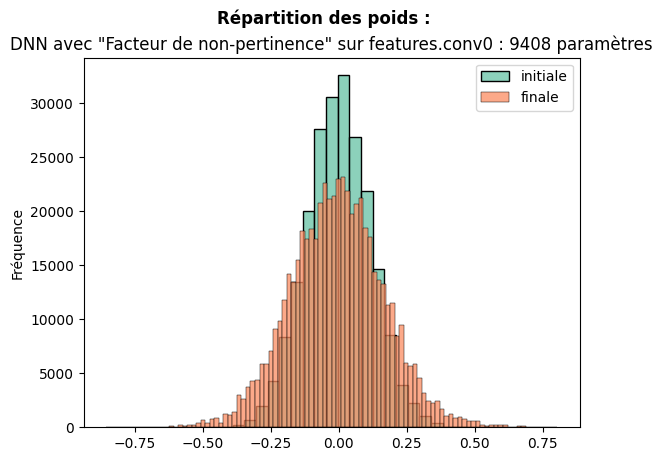

In [48]:
distrib_weight_simple('DNN', '"Facteur de non-pertinence"', model, 'features.conv0.weight')

## Courbes d'apprentissage

In [ ]:
path_file1 = 'DNN_irr_lambda1.csv'
model_l1 = preprocess_csv(path_file1)
path_file2 = 'DNN_irr_lambda2.csv'
model_l2 = preprocess_csv(path_file2)
path_file3 = 'DNN_irr_lambda3.csv'
model_l3 = preprocess_csv(path_file3)
path_file0 = 'DNN_no_reg.csv'
model_l0 = preprocess_csv(path_file0)

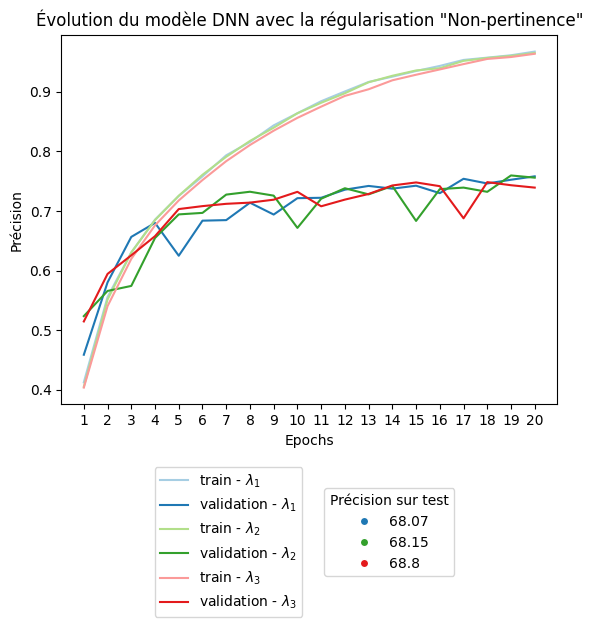

In [ ]:
plot_per_epoch_lambdacomp("DNN", '"Non-pertinence"', model_l1, model_l2, model_l3, model_l0, False)